# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

#from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


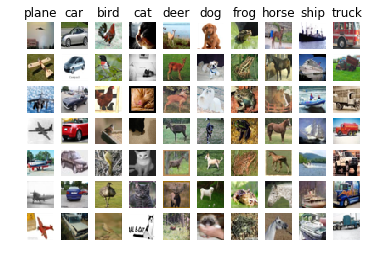

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


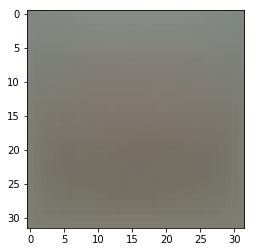

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

(500, 3073) (3073, 10)
loss: 8.815863


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
numerical: 11.212041 analytic: 11.212041, relative error: 4.469315e-12
(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
numerical: -0.612958 analytic: -0.612958, relative error: 1.112419e-10
(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
numerical: 0.977786 analytic: 0.977786, relative error: 2.464449e-10
(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
numerical: -3.845349 analytic: -3.845349, relative error: 2.377983e-11
(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
numerical: -1.955912 analytic: -1.955912, relative error: 8.908970e-11
(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
numerical: 18.296284 analytic: 18.296284, relative error: 8.002997e-12
(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
numerical: 12.078599 analytic: 12.078599, relative error: 3.077991e-11
(500, 3073) (3073, 10)
(500, 3073) (3073, 10)
numerical: 12.415462 analytic: 12.415462, relative error: 1.098110e-12
(500, 3073) (3073, 10)
(500, 3073) (3073, 1

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *Here we are using the so-called 'Hinge_function', the derivative of it at point (1, 0) do not exist. In analatical approach the derivative of the loss functin is regarded as 0*

In [17]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

(500, 3073) (3073, 10)
Naive loss: 8.815863e+00 computed in 0.635465s
Vectorized loss: 8.815863e+00 computed in 0.038350s
difference: 0.000000


In [18]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

(500, 3073) (3073, 10)
Naive loss and gradient: computed in 0.092450s
Vectorized loss and gradient: computed in 0.010786s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [36]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 25.279104
iteration 100 / 1500: loss 9.825952
iteration 200 / 1500: loss 7.724454
iteration 300 / 1500: loss 5.578524
iteration 400 / 1500: loss 5.176154
iteration 500 / 1500: loss 5.769350
iteration 600 / 1500: loss 4.810932
iteration 700 / 1500: loss 4.961180
iteration 800 / 1500: loss 4.955920
iteration 900 / 1500: loss 4.788258
iteration 1000 / 1500: loss 4.544538
iteration 1100 / 1500: loss 4.363948
iteration 1200 / 1500: loss 5.159874
iteration 1300 / 1500: loss 4.605480
iteration 1400 / 1500: loss 4.511360
That took 9.897596s


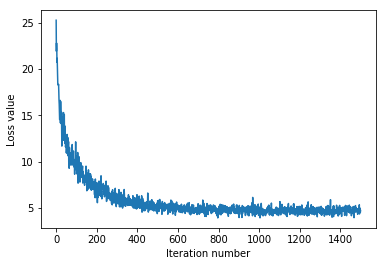

In [37]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [38]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.376367
validation accuracy: 0.376000


In [50]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [1.25e4, 2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for li in learning_rates:
    for ri in regularization_strengths:
        svm =LinearSVM()
        tic = time.time()
        loss_hist = svm.train(X_train, y_train, learning_rate=li, reg=ri,
                      num_iters=3000, verbose=True)
        y_train_pred = svm.predict(X_train)
        accuracy_train = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % accuracy_train)
        y_val_pred = svm.predict(X_val)
        accuracy_val = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % accuracy_val)
        results[(li, ri)] = accuracy_train, accuracy_val
        if accuracy_val > best_val:
            best_val = accuracy_val
            best_svm = svm
        toc = time.time()
        print('That took %fs' % (toc - tic))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

[[ 0.00111242 -0.00109259 -0.00055012 ... -0.00024311  0.00033595
   0.00011218]
 [ 0.00070503  0.00027244 -0.00025272 ...  0.00023011 -0.00115105
   0.00058382]
 [ 0.00090144 -0.00234294 -0.00034998 ...  0.00141371 -0.00015782
  -0.0012016 ]
 ...
 [-0.00131567  0.00086611 -0.00158854 ...  0.00048524  0.00069375
   0.00128024]
 [ 0.0001919  -0.00073389 -0.0004026  ... -0.00165506  0.00073181
   0.00071927]
 [ 0.00110978  0.0005277  -0.00135127 ... -0.00030672  0.00120006
   0.00085041]]
iteration 0 / 3000: loss 22.766687
[[ 0.00110909 -0.00108792 -0.00054634 ... -0.00024325  0.00033701
   0.00011165]
 [ 0.00070442  0.00027017 -0.00025016 ...  0.0002279  -0.00114161
   0.00058077]
 [ 0.00090102 -0.00233143 -0.00034721 ...  0.00140594 -0.00015174
  -0.00119603]
 ...
 [-0.00130708  0.00086295 -0.00158017 ...  0.00048408  0.00068879
   0.0012734 ]
 [ 0.00019364 -0.0007284  -0.00040058 ... -0.00164599  0.00072841
   0.00071532]
 [ 0.00110423  0.00052506 -0.00134452 ... -0.00030522  0.001194

[[ 9.65002905e-04 -9.06300890e-04 -4.57657477e-04 ... -2.11362156e-04
   2.92856727e-04  9.42234960e-05]
 [ 6.34012349e-04  2.54707786e-04 -1.91986354e-04 ...  1.96232787e-04
  -9.59851392e-04  4.98147017e-04]
 [ 8.41517715e-04 -1.98390947e-03 -2.75503292e-04 ...  1.21495002e-03
  -7.42089137e-05 -1.03278170e-03]
 ...
 [-1.10617845e-03  7.93670919e-04 -1.36460256e-03 ...  4.15238629e-04
   5.56570608e-04  1.10342414e-03]
 [ 2.11144935e-04 -5.75754857e-04 -3.47141532e-04 ... -1.42992764e-03
   6.23193632e-04  6.16863517e-04]
 [ 9.50089503e-04  4.51658927e-04 -1.15676123e-03 ... -2.62688040e-04
   1.02737650e-03  7.27642523e-04]]
[[ 9.58349458e-04 -9.00338113e-04 -4.56627713e-04 ... -2.10942166e-04
   2.91421967e-04  9.52142805e-05]
 [ 6.29271714e-04  2.53405695e-04 -1.90388693e-04 ...  1.94892132e-04
  -9.55014363e-04  4.97698956e-04]
 [ 8.36956022e-04 -1.97415954e-03 -2.73359699e-04 ...  1.20872103e-03
  -7.33734451e-05 -1.02544579e-03]
 ...
 [-1.10163061e-03  7.91624446e-04 -1.3592638

[[ 8.46254320e-04 -7.99189331e-04 -4.11617659e-04 ... -1.90150621e-04
   2.54681755e-04  8.80920914e-05]
 [ 5.58104982e-04  2.25242089e-04 -1.65951174e-04 ...  1.77628634e-04
  -8.48832908e-04  4.47474589e-04]
 [ 7.59186301e-04 -1.76281097e-03 -2.45616464e-04 ...  1.08845921e-03
  -4.68222359e-05 -9.11945905e-04]
 ...
 [-9.89122958e-04  7.24894060e-04 -1.21731431e-03 ...  3.63888125e-04
   4.80599710e-04  9.91652403e-04]
 [ 1.93939200e-04 -4.90884537e-04 -3.19443813e-04 ... -1.28002816e-03
   5.56276348e-04  5.56266527e-04]
 [ 8.42285789e-04  4.00382254e-04 -1.02554486e-03 ... -2.32737788e-04
   9.10746434e-04  6.44874234e-04]]
[[ 8.40445406e-04 -7.93127706e-04 -4.10541797e-04 ... -1.89613257e-04
   2.53200654e-04  8.68654080e-05]
 [ 5.54428476e-04  2.25982888e-04 -1.65677970e-04 ...  1.76438073e-04
  -8.44870508e-04  4.45290552e-04]
 [ 7.55655396e-04 -1.75148816e-03 -2.45580993e-04 ...  1.08274028e-03
  -4.64557529e-05 -9.06988910e-04]
 ...
 [-9.85187705e-04  7.23168159e-04 -1.2118328

[[ 7.06357431e-04 -6.76901779e-04 -3.52460640e-04 ... -1.62450375e-04
   2.07229519e-04  8.01729104e-05]
 [ 4.66844574e-04  1.85342865e-04 -1.34982868e-04 ...  1.56272257e-04
  -7.21285051e-04  3.89448542e-04]
 [ 6.52260576e-04 -1.50009145e-03 -2.10685625e-04 ...  9.36387391e-04
  -2.40334546e-05 -7.58096586e-04]
 ...
 [-8.43139850e-04  6.38588589e-04 -1.03923072e-03 ...  3.04926424e-04
   3.97749194e-04  8.57265787e-04]
 [ 1.69867777e-04 -3.92080748e-04 -2.83027750e-04 ... -1.10059745e-03
   4.79849243e-04  4.86756326e-04]
 [ 7.13609994e-04  3.39206307e-04 -8.68893059e-04 ... -1.97171537e-04
   7.71482154e-04  5.46285855e-04]]
[[ 7.02004317e-04 -6.72790585e-04 -3.51556509e-04 ... -1.63694468e-04
   2.06689223e-04  8.05941810e-05]
 [ 4.63723233e-04  1.85139288e-04 -1.35017835e-04 ...  1.53658133e-04
  -7.16966735e-04  3.88121153e-04]
 [ 6.48892853e-04 -1.49161855e-03 -2.11369777e-04 ...  9.30472793e-04
  -2.29194438e-05 -7.53911811e-04]
 ...
 [-8.40004048e-04  6.37744682e-04 -1.0361321

[[ 6.01368924e-04 -5.75893929e-04 -3.10439907e-04 ... -1.49199435e-04
   1.76524844e-04  7.22427982e-05]
 [ 3.96101055e-04  1.57738336e-04 -1.14039871e-04 ...  1.29477183e-04
  -6.14654828e-04  3.39927676e-04]
 [ 5.69257731e-04 -1.28470952e-03 -1.87240822e-04 ...  8.01992683e-04
  -7.88994710e-06 -6.36633899e-04]
 ...
 [-7.29243042e-04  5.61841961e-04 -8.93052700e-04 ...  2.57070368e-04
   3.37911623e-04  7.45462394e-04]
 [ 1.47151342e-04 -3.21005116e-04 -2.52198894e-04 ... -9.59472866e-04
   4.21627636e-04  4.29395469e-04]
 [ 6.10837968e-04  2.90328248e-04 -7.43273761e-04 ... -1.68628581e-04
   6.59991528e-04  4.67331423e-04]]
[[ 5.97428492e-04 -5.71671138e-04 -3.10041059e-04 ... -1.48464117e-04
   1.75967379e-04  7.02107498e-05]
 [ 3.93060239e-04  1.57998635e-04 -1.14540062e-04 ...  1.28561788e-04
  -6.10963929e-04  3.37522291e-04]
 [ 5.65288999e-04 -1.27636924e-03 -1.88253462e-04 ...  7.98127456e-04
  -7.00728203e-06 -6.33266331e-04]
 ...
 [-7.26677174e-04  5.60157182e-04 -8.8917910

[[ 5.22345312e-04 -4.94167749e-04 -2.70135568e-04 ... -1.39458018e-04
   1.50244321e-04  6.33159310e-05]
 [ 3.41452629e-04  1.38378007e-04 -9.21527480e-05 ...  1.06933592e-04
  -5.36442133e-04  3.01036994e-04]
 [ 4.98645939e-04 -1.11340176e-03 -1.66368641e-04 ...  7.00956798e-04
  -5.06137831e-07 -5.40967662e-04]
 ...
 [-6.39171533e-04  4.97621689e-04 -7.88154993e-04 ...  2.22425163e-04
   2.93772253e-04  6.58315196e-04]
 [ 1.25642299e-04 -2.66340803e-04 -2.38800924e-04 ... -8.40816453e-04
   3.76713950e-04  3.84979738e-04]
 [ 5.30585407e-04  2.52188942e-04 -6.45667585e-04 ... -1.46395243e-04
   5.73147221e-04  4.05930271e-04]]
[[ 5.19619676e-04 -4.92424171e-04 -2.69285505e-04 ... -1.39437228e-04
   1.49982444e-04  6.23109695e-05]
 [ 3.38413564e-04  1.36435925e-04 -9.17529545e-05 ...  1.06260425e-04
  -5.33303659e-04  2.99167519e-04]
 [ 4.95126529e-04 -1.10958277e-03 -1.65882541e-04 ...  6.97625014e-04
   2.35053797e-07 -5.38254773e-04]
 ...
 [-6.37040453e-04  4.95347131e-04 -7.8405821

[[ 4.58383276e-04 -4.40708066e-04 -2.34058381e-04 ... -1.26870308e-04
   1.31152648e-04  5.29205563e-05]
 [ 2.96633020e-04  1.11310563e-04 -7.34617983e-05 ...  9.26540459e-05
  -4.71933886e-04  2.67175764e-04]
 [ 4.40636725e-04 -9.86079830e-04 -1.49007724e-04 ...  6.17503337e-04
   1.72801855e-06 -4.67530691e-04]
 ...
 [-5.67785156e-04  4.47978943e-04 -6.90297176e-04 ...  1.99447399e-04
   2.56822605e-04  5.86380865e-04]
 [ 1.04371159e-04 -2.21524496e-04 -2.14024226e-04 ... -7.44855708e-04
   3.37460429e-04  3.46700674e-04]
 [ 4.65501156e-04  2.21318237e-04 -5.66333839e-04 ... -1.28402702e-04
   5.02767005e-04  3.56194061e-04]]
[[ 4.55224556e-04 -4.39305705e-04 -2.31963988e-04 ... -1.27346882e-04
   1.30978230e-04  5.22364943e-05]
 [ 2.94266508e-04  1.09946501e-04 -7.20294230e-05 ...  9.14338305e-05
  -4.69216454e-04  2.65777301e-04]
 [ 4.37878546e-04 -9.82211694e-04 -1.47252877e-04 ...  6.13590899e-04
   2.17903939e-06 -4.64801872e-04]
 ...
 [-5.65422353e-04  4.45504479e-04 -6.8688691

[[ 3.96502270e-04 -3.80327684e-04 -1.96165973e-04 ... -1.15386567e-04
   1.11484888e-04  4.47862323e-05]
 [ 2.55045927e-04  9.24279576e-05 -5.51271329e-05 ...  8.23032916e-05
  -4.09720635e-04  2.36208364e-04]
 [ 3.86491477e-04 -8.55703876e-04 -1.32627532e-04 ...  5.43687665e-04
   6.45962391e-06 -3.90310659e-04]
 ...
 [-4.91013024e-04  3.95190715e-04 -5.95982767e-04 ...  1.75117577e-04
   2.19701231e-04  5.10944857e-04]
 [ 9.52351374e-05 -1.84032580e-04 -1.89351415e-04 ... -6.58917142e-04
   2.99820301e-04  3.04629982e-04]
 [ 4.02347407e-04  1.91310707e-04 -4.89334520e-04 ... -1.10765755e-04
   4.34354992e-04  3.07776113e-04]]
[[ 3.94195492e-04 -3.79364380e-04 -1.94504420e-04 ... -1.16385435e-04
   1.10887609e-04  4.46531355e-05]
 [ 2.52952378e-04  9.13530712e-05 -5.41598328e-05 ...  8.11566678e-05
  -4.07673662e-04  2.35108069e-04]
 [ 3.83880313e-04 -8.51567458e-04 -1.31529659e-04 ...  5.40982038e-04
   6.66667597e-06 -3.88631504e-04]
 ...
 [-4.89087874e-04  3.93314898e-04 -5.9313911

[[ 3.60055860e-04 -3.46637702e-04 -1.79571575e-04 ... -1.07958556e-04
   9.88344099e-05  4.56881360e-05]
 [ 2.29060255e-04  8.31118710e-05 -4.79821464e-05 ...  7.66641613e-05
  -3.74823076e-04  2.20559652e-04]
 [ 3.50190149e-04 -7.75885704e-04 -1.26680035e-04 ...  5.01495648e-04
   7.28006409e-06 -3.44773678e-04]
 ...
 [-4.47997112e-04  3.58864051e-04 -5.39426216e-04 ...  1.61416224e-04
   1.98721430e-04  4.64163241e-04]
 [ 8.69034264e-05 -1.67361407e-04 -1.72949607e-04 ... -6.03269030e-04
   2.77014024e-04  2.77277384e-04]
 [ 3.65611123e-04  1.73730316e-04 -4.44625109e-04 ... -1.00579672e-04
   3.94536262e-04  2.79667826e-04]]
[[ 3.58208703e-04 -3.45699963e-04 -1.79142734e-04 ... -1.05167040e-04
   9.68774406e-05  4.64250704e-05]
 [ 2.27960552e-04  8.18965948e-05 -4.84898795e-05 ...  7.83395049e-05
  -3.74250180e-04  2.20693016e-04]
 [ 3.47862125e-04 -7.72723121e-04 -1.27529377e-04 ...  5.01676904e-04
   6.06785079e-06 -3.41598542e-04]
 ...
 [-4.45895663e-04  3.57922870e-04 -5.3675339

[[ 3.19100220e-04 -3.02603996e-04 -1.50981964e-04 ... -9.64346271e-05
   8.87137253e-05  3.58354162e-05]
 [ 2.02974532e-04  7.50594702e-05 -3.08074250e-05 ...  6.98276378e-05
  -3.31062479e-04  1.96895552e-04]
 [ 3.15762064e-04 -6.84660463e-04 -1.13002552e-04 ...  4.50510087e-04
   1.20736850e-05 -2.98807072e-04]
 ...
 [-4.00284592e-04  3.18008972e-04 -4.79454894e-04 ...  1.46152730e-04
   1.75967637e-04  4.22010131e-04]
 [ 7.47092723e-05 -1.48027068e-04 -1.58262996e-04 ... -5.40758695e-04
   2.51623581e-04  2.56870469e-04]
 [ 3.24068609e-04  1.53879644e-04 -3.93839190e-04 ... -8.89965585e-05
   3.49452768e-04  2.47712823e-04]]
[[ 3.15856057e-04 -2.99900446e-04 -1.49754720e-04 ... -9.49828864e-05
   8.79610756e-05  3.59739858e-05]
 [ 2.00163294e-04  7.55185724e-05 -3.04866413e-05 ...  7.04199265e-05
  -3.29299350e-04  1.96525010e-04]
 [ 3.12590732e-04 -6.80242054e-04 -1.14007937e-04 ...  4.49533932e-04
   1.25990557e-05 -2.96277378e-04]
 ...
 [-3.99836930e-04  3.18106668e-04 -4.7740775

[[ 2.78068998e-04 -2.61478589e-04 -1.27439688e-04 ... -8.78773004e-05
   7.66115360e-05  3.28838937e-05]
 [ 1.76615122e-04  6.73244110e-05 -2.12156687e-05 ...  6.40429380e-05
  -2.91838171e-04  1.78508280e-04]
 [ 2.80990984e-04 -5.97217626e-04 -1.04533138e-04 ...  4.03521840e-04
   1.46769562e-05 -2.49762559e-04]
 ...
 [-3.62257001e-04  2.90338994e-04 -4.22744336e-04 ...  1.26959013e-04
   1.47081721e-04  3.73146890e-04]
 [ 5.64901869e-05 -1.17456207e-04 -1.46540316e-04 ... -4.85985819e-04
   2.22410520e-04  2.28644789e-04]
 [ 2.84168505e-04  1.35000440e-04 -3.45452815e-04 ... -7.79524110e-05
   3.06359506e-04  2.17342436e-04]]
[[ 2.77606782e-04 -2.59310666e-04 -1.26805142e-04 ... -8.81857519e-05
   7.67547183e-05  3.34014809e-05]
 [ 1.76462772e-04  6.77616885e-05 -2.11050880e-05 ...  6.31210886e-05
  -2.89997672e-04  1.78758366e-04]
 [ 2.79782138e-04 -5.93332431e-04 -1.04656005e-04 ...  4.00900752e-04
   1.54315476e-05 -2.47048564e-04]
 ...
 [-3.60043787e-04  2.88837540e-04 -4.1975231

[[ 2.41726865e-04 -2.25097332e-04 -1.13921385e-04 ... -8.01187702e-05
   6.51496079e-05  2.84115037e-05]
 [ 1.50947205e-04  5.85574602e-05 -1.99824213e-05 ...  5.42102085e-05
  -2.54820740e-04  1.60153118e-04]
 [ 2.50122847e-04 -5.16608927e-04 -1.03212687e-04 ...  3.56003740e-04
   1.54616501e-05 -2.04509061e-04]
 ...
 [-3.24727480e-04  2.53612717e-04 -3.67956641e-04 ...  1.16073113e-04
   1.25877927e-04  3.27011955e-04]
 [ 4.31490960e-05 -9.95931374e-05 -1.31550405e-04 ... -4.24360500e-04
   1.96144937e-04  2.02192558e-04]
 [ 2.46789140e-04  1.17231999e-04 -2.99857097e-04 ... -6.76359717e-05
   2.65799920e-04  1.88679905e-04]]
[[ 2.39427484e-04 -2.23543690e-04 -1.12063853e-04 ... -7.96334431e-05
   6.41598160e-05  2.91892470e-05]
 [ 1.48982533e-04  5.87574103e-05 -1.88790640e-05 ...  5.39173378e-05
  -2.53752292e-04  1.60484460e-04]
 [ 2.47411574e-04 -5.13748544e-04 -1.02205202e-04 ...  3.54163515e-04
   1.54193702e-05 -2.01833326e-04]
 ...
 [-3.22899860e-04  2.52873448e-04 -3.6540177

[[ 2.24502282e-04 -2.07325251e-04 -1.08713206e-04 ... -7.36008110e-05
   6.18261507e-05  2.46337408e-05]
 [ 1.39272669e-04  5.42353908e-05 -1.96978693e-05 ...  5.37884800e-05
  -2.34318664e-04  1.48959522e-04]
 [ 2.34858328e-04 -4.79820120e-04 -1.00992370e-04 ...  3.37087613e-04
   1.92369779e-05 -1.85365062e-04]
 ...
 [-3.05518139e-04  2.40830386e-04 -3.45154126e-04 ...  1.13791495e-04
   1.14257702e-04  3.08872527e-04]
 [ 3.58776854e-05 -8.48058099e-05 -1.26922175e-04 ... -3.94179892e-04
   1.83078102e-04  1.92926562e-04]
 [ 2.28880131e-04  1.08617194e-04 -2.78076462e-04 ... -6.26570149e-05
   2.46371603e-04  1.74939956e-04]]
[[ 2.24133047e-04 -2.06590348e-04 -1.08089768e-04 ... -7.28059354e-05
   6.08218883e-05  2.48907986e-05]
 [ 1.39835641e-04  5.31715494e-05 -1.96081060e-05 ...  5.38478116e-05
  -2.33906536e-04  1.48977776e-04]
 [ 2.34911802e-04 -4.78181754e-04 -1.00829017e-04 ...  3.35761566e-04
   1.81708780e-05 -1.83591126e-04]
 ...
 [-3.02904291e-04  2.38493992e-04 -3.4410378

[[ 2.08993575e-04 -1.90116079e-04 -1.02856290e-04 ... -7.30601997e-05
   5.89311917e-05  2.36604023e-05]
 [ 1.30486143e-04  5.01728780e-05 -2.09763378e-05 ...  4.91320154e-05
  -2.16356162e-04  1.42660723e-04]
 [ 2.21794585e-04 -4.43658333e-04 -1.01232011e-04 ...  3.14411355e-04
   2.04522223e-05 -1.64338941e-04]
 ...
 [-2.83116701e-04  2.24804115e-04 -3.19427817e-04 ...  1.10521644e-04
   1.01719096e-04  2.88855452e-04]
 [ 3.19014750e-05 -7.53752380e-05 -1.17430048e-04 ... -3.67151351e-04
   1.70166308e-04  1.79827401e-04]
 [ 2.12200759e-04  1.00685166e-04 -2.57725503e-04 ... -5.80413866e-05
   2.28277307e-04  1.62037257e-04]]
[[ 2.07962976e-04 -1.89651617e-04 -1.02202884e-04 ... -7.10416892e-05
   5.80618061e-05  2.31288774e-05]
 [ 1.29641747e-04  4.90493036e-05 -2.05891182e-05 ...  5.07172640e-05
  -2.16097673e-04  1.42242255e-04]
 [ 2.20262197e-04 -4.42479092e-04 -1.00894119e-04 ...  3.14841667e-04
   1.94540439e-05 -1.62894981e-04]
 ...
 [-2.82409138e-04  2.23485507e-04 -3.1705612

[[ 1.91797864e-04 -1.72592307e-04 -9.15015744e-05 ... -7.04487634e-05
   5.56175761e-05  2.04617558e-05]
 [ 1.20915514e-04  4.67796189e-05 -1.54100553e-05 ...  4.50919729e-05
  -2.00244674e-04  1.35072074e-04]
 [ 2.09852573e-04 -4.11982894e-04 -9.47694830e-05 ...  2.92356524e-04
   2.16853270e-05 -1.48048755e-04]
 ...
 [-2.65733563e-04  2.06824145e-04 -2.97183171e-04 ...  1.07654511e-04
   9.55057574e-05  2.71808966e-04]
 [ 3.03192654e-05 -6.98896181e-05 -1.10587690e-04 ... -3.44251319e-04
   1.61849222e-04  1.70072000e-04]
 [ 1.97767634e-04  9.38193635e-05 -2.40072840e-04 ... -5.40414055e-05
   2.12582964e-04  1.50917217e-04]]
[[ 1.90907578e-04 -1.71177007e-04 -9.13731274e-05 ... -7.10562998e-05
   5.57074443e-05  2.11967004e-05]
 [ 1.20430217e-04  4.68708555e-05 -1.48308041e-05 ...  4.39659377e-05
  -1.99041606e-04  1.35836278e-04]
 [ 2.09246497e-04 -4.09664501e-04 -9.26328487e-05 ...  2.90341170e-04
   2.15454286e-05 -1.45261670e-04]
 ...
 [-2.63673051e-04  2.05612263e-04 -2.9429073

[[ 1.72700830e-04 -1.53639265e-04 -8.25011201e-05 ... -6.57410050e-05
   5.28948346e-05  2.39990717e-05]
 [ 1.08349543e-04  4.52756967e-05 -1.12448785e-05 ...  4.31022461e-05
  -1.82385164e-04  1.30680200e-04]
 [ 1.94771825e-04 -3.74536270e-04 -8.86944564e-05 ...  2.74248198e-04
   2.31884989e-05 -1.25214842e-04]
 ...
 [-2.49456205e-04  1.95449335e-04 -2.72681775e-04 ...  1.02246645e-04
   8.12271707e-05  2.52997074e-04]
 [ 2.04941083e-05 -5.71605665e-05 -9.98548646e-05 ... -3.18122796e-04
   1.47070201e-04  1.60020481e-04]
 [ 1.80549673e-04  8.55557813e-05 -2.19120210e-04 ... -4.93630913e-05
   1.94018102e-04  1.37780353e-04]]
[[ 1.71961961e-04 -1.55196694e-04 -8.26815773e-05 ... -6.85611245e-05
   5.44998099e-05  2.34490021e-05]
 [ 1.08439650e-04  4.27004803e-05 -1.13081268e-05 ...  3.92528559e-05
  -1.79547521e-04  1.30223244e-04]
 [ 1.94709257e-04 -3.75199321e-04 -8.90526950e-05 ...  2.69413344e-04
   2.52359021e-05 -1.23627346e-04]
 ...
 [-2.47341528e-04  1.93248535e-04 -2.7214315

[[ 1.55582808e-04 -1.35895230e-04 -7.56128011e-05 ... -5.67711177e-05
   4.99504771e-05  1.60834934e-05]
 [ 9.67323557e-05  4.00995556e-05 -1.15621891e-05 ...  4.45142284e-05
  -1.60922005e-04  1.15636239e-04]
 [ 1.77940203e-04 -3.32298800e-04 -8.94419106e-05 ...  2.56069821e-04
   2.59270182e-05 -1.08812046e-04]
 ...
 [-2.25592634e-04  1.80961240e-04 -2.46880951e-04 ...  9.47247406e-05
   6.86647859e-05  2.33122174e-04]
 [ 1.57368782e-05 -4.23448544e-05 -9.70305575e-05 ... -2.88294708e-04
   1.33766396e-04  1.50182822e-04]
 [ 1.60616220e-04  7.62776674e-05 -1.94979033e-04 ... -4.38386661e-05
   1.72514146e-04  1.22550248e-04]]
[[ 1.53153158e-04 -1.35220274e-04 -7.50884399e-05 ... -5.78347012e-05
   5.19744713e-05  1.82713598e-05]
 [ 9.46632738e-05  4.01631742e-05 -1.19506590e-05 ...  4.37149563e-05
  -1.57848958e-04  1.16933521e-04]
 [ 1.75431902e-04 -3.30711354e-04 -8.97243880e-05 ...  2.54636185e-04
   2.83035418e-05 -1.05905538e-04]
 ...
 [-2.25214846e-04  1.80453035e-04 -2.4550938

[[ 1.32108232e-04 -1.15597526e-04 -5.88146454e-05 ... -4.69227787e-05
   4.51270878e-05  9.75107475e-06]
 [ 8.41689919e-05  3.29483083e-05 -1.11380466e-06 ...  4.13978846e-05
  -1.34448969e-04  1.02467852e-04]
 [ 1.60334860e-04 -2.81591270e-04 -7.71262414e-05 ...  2.25038843e-04
   2.74080730e-05 -8.15351338e-05]
 ...
 [-1.93867516e-04  1.55369050e-04 -2.07749156e-04 ...  8.93105434e-05
   6.09776221e-05  2.02847685e-04]
 [ 1.02289200e-05 -3.09882962e-05 -8.38660531e-05 ... -2.53643092e-04
   1.23370429e-04  1.32353234e-04]
 [ 1.36588316e-04  6.46860220e-05 -1.65653734e-04 ... -3.70736630e-05
   1.46433755e-04  1.04128355e-04]]
[[ 1.32483252e-04 -1.15956062e-04 -5.73581634e-05 ... -4.75170771e-05
   4.65660437e-05  9.53250201e-06]
 [ 8.46454460e-05  3.15672951e-05 -1.76434257e-07 ...  4.06992057e-05
  -1.32359026e-04  1.02046910e-04]
 [ 1.60525899e-04 -2.81521738e-04 -7.62499299e-05 ...  2.24219092e-04
   2.90078523e-05 -8.10103189e-05]
 ...
 [-1.91483197e-04  1.55474930e-04 -2.0677563

   1.24919137e-04  8.88203284e-05]]
[[ 1.09909551e-04 -9.99558855e-05 -4.67479374e-05 ... -4.14563339e-05
   4.14567513e-05  8.58172540e-06]
 [ 7.12722986e-05  2.21360856e-05  4.49320958e-06 ...  3.55454295e-05
  -1.10805794e-04  9.08942201e-05]
 [ 1.43396272e-04 -2.44173319e-04 -6.90132264e-05 ...  1.98384698e-04
   3.17195725e-05 -6.12150459e-05]
 ...
 [-1.64964626e-04  1.40365588e-04 -1.68680330e-04 ...  8.14175192e-05
   4.37381176e-05  1.75532596e-04]
 [ 1.07246538e-05 -1.53526583e-05 -7.06983887e-05 ... -2.22005530e-04
   1.05057102e-04  1.17803850e-04]
 [ 1.16026430e-04  5.50935632e-05 -1.40705559e-04 ... -3.14155574e-05
   1.24276541e-04  8.83782268e-05]]
[[ 1.11189298e-04 -9.81992614e-05 -4.93513329e-05 ... -4.10223158e-05
   4.10150522e-05  1.04459081e-05]
 [ 7.26254166e-05  2.27051677e-05  2.38538965e-06 ...  3.61276225e-05
  -1.10155195e-04  9.23489476e-05]
 [ 1.44477797e-04 -2.42055792e-04 -7.05194516e-05 ...  1.97983875e-04
   3.19156117e-05 -5.89706510e-05]
 ...
 [-1.628

[[ 9.60977981e-05 -8.55626423e-05 -4.79022828e-05 ... -3.54634778e-05
   3.74193298e-05  1.67131283e-05]
 [ 6.36115369e-05  1.67879676e-05 -2.53044944e-06 ...  3.79345002e-05
  -9.33930967e-05  9.18650987e-05]
 [ 1.32151663e-04 -2.12728639e-04 -7.67768942e-05 ...  1.86846693e-04
   3.74170988e-05 -3.75761616e-05]
 ...
 [-1.45917104e-04  1.22294561e-04 -1.50086383e-04 ...  7.99966663e-05
   3.19042326e-05  1.64540811e-04]
 [ 5.91089459e-06 -8.86460615e-06 -6.70876632e-05 ... -1.94055268e-04
   9.08874086e-05  1.16281789e-04]
 [ 1.00636069e-04  4.77950666e-05 -1.21925820e-04 ... -2.71979050e-05
   1.07565677e-04  7.67132931e-05]]
[[ 9.52287281e-05 -8.49490082e-05 -4.86699102e-05 ... -3.50619917e-05
   3.82361691e-05  1.63799816e-05]
 [ 6.29537966e-05  1.67870186e-05 -3.66003918e-06 ...  3.84218209e-05
  -9.20431701e-05  9.13555906e-05]
 [ 1.31359644e-04 -2.11949259e-04 -7.81726773e-05 ...  1.87740663e-04
   3.80584939e-05 -3.69405416e-05]
 ...
 [-1.45526899e-04  1.22090520e-04 -1.5021972

[[ 8.50516412e-05 -7.54639830e-05 -4.58821203e-05 ... -2.99473328e-05
   3.66379781e-05  1.42372447e-05]
 [ 5.55497035e-05  1.21139777e-05 -3.65194365e-06 ...  3.68319741e-05
  -7.57630049e-05  8.50421864e-05]
 [ 1.19989019e-04 -1.90859023e-04 -7.33069777e-05 ...  1.71777153e-04
   4.45046701e-05 -2.19268137e-05]
 ...
 [-1.31061832e-04  1.11285162e-04 -1.34166055e-04 ...  7.94939269e-05
   2.72709507e-05  1.46051783e-04]
 [-1.99283398e-08 -7.02884393e-07 -6.46780635e-05 ... -1.72302035e-04
   8.70231887e-05  1.05572069e-04]
 [ 8.81807626e-05  4.19877102e-05 -1.06682544e-04 ... -2.37076146e-05
   9.40828847e-05  6.70361396e-05]]
[[ 8.36323593e-05 -7.41560042e-05 -4.60691725e-05 ... -2.72622076e-05
   3.53940957e-05  1.34850822e-05]
 [ 5.44946833e-05  1.26450334e-05 -3.84965653e-06 ...  3.95077321e-05
  -7.66799547e-05  8.39027472e-05]
 [ 1.18871650e-04 -1.89117512e-04 -7.40891536e-05 ...  1.74209400e-04
   4.26410186e-05 -2.22277556e-05]
 ...
 [-1.31418298e-04  1.10905406e-04 -1.3400951

[[ 7.38592637e-05 -6.28830887e-05 -3.47134371e-05 ... -2.88554859e-05
   3.29705749e-05  1.32938536e-05]
 [ 4.82430876e-05  9.20871434e-06  3.21085494e-06 ...  3.37648694e-05
  -6.48637168e-05  8.13664654e-05]
 [ 1.09605762e-04 -1.63727564e-04 -6.79754514e-05 ...  1.56106903e-04
   4.28788138e-05 -6.83955029e-06]
 ...
 [-1.17534906e-04  9.93015352e-05 -1.22659802e-04 ...  8.11640672e-05
   1.59710837e-05  1.37195306e-04]
 [-4.39132965e-06  6.43968444e-06 -6.55753736e-05 ... -1.50465800e-04
   7.43827929e-05  1.03441273e-04]
 [ 7.63478250e-05  3.63056693e-05 -9.23456657e-05 ... -2.04201980e-05
   8.12919772e-05  5.80127663e-05]]
[[ 7.22815318e-05 -6.21971867e-05 -3.53217925e-05 ... -2.84894654e-05
   3.36329924e-05  1.38826986e-05]
 [ 4.68525594e-05  9.25391506e-06  2.44459520e-06 ...  3.41570930e-05
  -6.33746905e-05  8.16254961e-05]
 [ 1.07871822e-04 -1.62586292e-04 -6.80201896e-05 ...  1.56382151e-04
   4.41355024e-05 -6.33429815e-06]
 ...
 [-1.17420374e-04  9.83925950e-05 -1.2206649

[[ 6.44317369e-05 -4.96063464e-05 -3.43601756e-05 ... -2.80538554e-05
   2.99233755e-05  1.25344087e-05]
 [ 4.51247765e-05  1.08404139e-05  1.06491127e-07 ...  2.94570883e-05
  -5.23007996e-05  7.35358074e-05]
 [ 1.04316801e-04 -1.38179348e-04 -7.12279896e-05 ...  1.40403309e-04
   4.79918571e-05  2.57777948e-07]
 ...
 [-1.09967885e-04  9.04978672e-05 -1.04272165e-04 ...  7.76817785e-05
   1.29572131e-05  1.20920857e-04]
 [-7.75101248e-06  1.07597085e-05 -5.76461626e-05 ... -1.34607167e-04
   7.17004539e-05  9.24049823e-05]
 [ 6.64449982e-05  3.16561192e-05 -8.03018706e-05 ... -1.78104398e-05
   7.05843853e-05  5.04167785e-05]]
[[ 6.42901020e-05 -5.01637471e-05 -3.46410032e-05 ... -2.68792145e-05
   2.94374345e-05  1.22066861e-05]
 [ 4.52559243e-05  9.84863880e-06 -7.85267349e-07 ...  2.96950768e-05
  -5.23485262e-05  7.33433452e-05]
 [ 1.04446641e-04 -1.38346055e-04 -7.34854584e-05 ...  1.40150684e-04
   4.75918545e-05  7.58834793e-07]
 ...
 [-1.08918271e-04  8.89988257e-05 -1.0388973

   5.85929246e-05  4.20143562e-05]]
[[ 5.58605150e-05 -4.44380159e-05 -3.22623839e-05 ... -1.33509857e-05
   2.44005995e-05  1.69563276e-05]
 [ 4.19716022e-05  2.11575321e-06 -2.75814506e-06 ...  3.62242811e-05
  -4.48115010e-05  7.40757197e-05]
 [ 9.73500701e-05 -1.19381245e-04 -7.13001833e-05 ...  1.32308163e-04
   4.24685897e-05  2.06137635e-05]
 ...
 [-9.68384007e-05  7.98135352e-05 -9.21850747e-05 ...  6.61576405e-05
   4.42567060e-06  1.13900800e-04]
 [-1.12518970e-05  1.77965137e-05 -5.79995770e-05 ... -1.23156650e-04
   6.16668863e-05  8.95039968e-05]
 [ 5.52018220e-05  2.63293381e-05 -6.65578453e-05 ... -1.46486309e-05
   5.82874599e-05  4.17932844e-05]]
[[ 5.49377228e-05 -4.52690791e-05 -3.16486803e-05 ... -1.41027308e-05
   2.40551811e-05  1.65998297e-05]
 [ 4.06372601e-05  8.65610516e-07 -1.71919678e-06 ...  3.54981597e-05
  -4.47023727e-05  7.36253046e-05]
 [ 9.57068786e-05 -1.19651680e-04 -7.07327434e-05 ...  1.31992622e-04
   4.23438838e-05  2.05906425e-05]
 ...
 [-9.728

[[ 4.37388544e-05 -3.76076968e-05 -2.50388377e-05 ... -1.14202956e-05
   2.32750192e-05  1.80492548e-05]
 [ 3.35070899e-05 -1.12452499e-06  1.15298849e-06 ...  3.64788742e-05
  -3.42204715e-05  6.90979751e-05]
 [ 8.84063920e-05 -1.05496735e-04 -7.08511654e-05 ...  1.28605370e-04
   4.38369655e-05  3.07716557e-05]
 ...
 [-9.13595928e-05  7.74867084e-05 -7.98912516e-05 ...  6.59387903e-05
   8.57284209e-07  1.02681807e-04]
 [-1.51237233e-05  2.61523552e-05 -5.55697490e-05 ... -1.06949378e-04
   5.59791922e-05  8.41592185e-05]
 [ 4.70101264e-05  2.24214420e-05 -5.64695025e-05 ... -1.23730013e-05
   4.94452151e-05  3.54839326e-05]]
[[ 4.26430657e-05 -3.82375165e-05 -2.32737854e-05 ... -1.15485388e-05
   2.42044955e-05  1.79827856e-05]
 [ 3.23676161e-05 -2.05142063e-06  2.86174181e-06 ...  3.58477172e-05
  -3.30984787e-05  6.90068208e-05]
 [ 8.70942341e-05 -1.05825277e-04 -6.80238835e-05 ...  1.27441182e-04
   4.45601242e-05  3.14260627e-05]
 ...
 [-9.08091078e-05  7.71046368e-05 -7.9402157

[[ 3.86190506e-05 -2.90016603e-05 -1.72567554e-05 ... -1.61046586e-05
   2.22874759e-05  2.19920112e-05]
 [ 2.88407660e-05  9.04901175e-08  8.34611258e-06 ...  2.72715374e-05
  -2.78128366e-05  7.03067434e-05]
 [ 8.06677173e-05 -8.95716562e-05 -5.95124563e-05 ...  1.12724119e-04
   4.28278357e-05  4.18295301e-05]
 ...
 [-8.83979389e-05  6.98578519e-05 -6.99303840e-05 ...  6.43199319e-05
  -2.99138177e-07  9.39362604e-05]
 [-2.23723270e-05  3.02560542e-05 -5.10210240e-05 ... -9.62117351e-05
   5.47992683e-05  7.67444613e-05]
 [ 4.00299671e-05  1.90905701e-05 -4.80502781e-05 ... -1.03712048e-05
   4.19165604e-05  3.00904898e-05]]
[[ 3.78294048e-05 -2.80119864e-05 -1.71508266e-05 ... -1.71075171e-05
   2.15389745e-05  2.30233112e-05]
 [ 2.73832791e-05  7.76791085e-07  8.59760350e-06 ...  2.64378897e-05
  -2.83978113e-05  7.13394014e-05]
 [ 7.96097244e-05 -8.89249000e-05 -5.77761138e-05 ...  1.11214548e-04
   4.17336771e-05  4.36044063e-05]
 ...
 [-8.93275889e-05  6.97581991e-05 -7.0744779

[[ 3.59781159e-05 -2.74528204e-05 -1.13771376e-05 ... -1.43188751e-05
   1.98864877e-05  1.93121873e-05]
 [ 2.86815283e-05 -9.15789865e-06  9.98206759e-06 ...  2.92530811e-05
  -1.98861636e-05  6.46212185e-05]
 [ 8.14008967e-05 -8.93838822e-05 -5.46492929e-05 ...  1.09249171e-04
   4.66723484e-05  4.79055522e-05]
 ...
 [-7.70548997e-05  6.13034648e-05 -6.43174534e-05 ...  6.53335712e-05
  -8.23817156e-06  8.59827049e-05]
 [-2.01261216e-05  3.08249957e-05 -5.20050726e-05 ... -8.62554982e-05
   4.95775345e-05  7.25046767e-05]
 [ 3.38466516e-05  1.62038981e-05 -4.05255285e-05 ... -8.69864623e-06
   3.52326602e-05  2.53323478e-05]]
[[ 3.65333538e-05 -2.48626374e-05 -1.18578329e-05 ... -1.46841661e-05
   1.94577818e-05  1.78819711e-05]
 [ 2.92123467e-05 -7.20279181e-06  9.32947460e-06 ...  2.89266376e-05
  -2.01116803e-05  6.35383749e-05]
 [ 8.19830009e-05 -8.68702236e-05 -5.52073073e-05 ...  1.08547099e-04
   4.59150977e-05  4.73106853e-05]
 ...
 [-7.63896958e-05  6.17925671e-05 -6.4661746

[[ 3.40237984e-05 -2.07351856e-05 -5.59814564e-06 ... -1.41770050e-05
   1.87731637e-05  1.77680493e-05]
 [ 2.67847841e-05 -7.60468087e-06  1.37702513e-05 ...  2.85709849e-05
  -1.68279482e-05  6.30554284e-05]
 [ 7.93517007e-05 -8.20768505e-05 -5.01765047e-05 ...  1.05828399e-04
   4.63463079e-05  5.20171528e-05]
 ...
 [-7.26941798e-05  5.98849752e-05 -5.81633458e-05 ...  6.13027695e-05
  -1.03737490e-05  8.42985642e-05]
 [-2.14091914e-05  3.46109456e-05 -4.90577592e-05 ... -8.41812879e-05
   4.79738457e-05  7.48294586e-05]
 [ 3.09387268e-05  1.48751881e-05 -3.69811306e-05 ... -7.89268650e-06
   3.21104433e-05  2.31181920e-05]]
[[ 3.36682336e-05 -2.02096820e-05 -6.39659761e-06 ... -1.43589610e-05
   1.84810987e-05  1.71406110e-05]
 [ 2.60530314e-05 -7.42353874e-06  1.29318110e-05 ...  2.84402555e-05
  -1.66627012e-05  6.19023248e-05]
 [ 7.80804727e-05 -8.13080467e-05 -5.09642853e-05 ...  1.05506972e-04
   4.64332656e-05  5.11195648e-05]
 ...
 [-7.31091936e-05  6.00519476e-05 -5.6831923

[[ 3.05221921e-05 -1.92669805e-05 -7.76117686e-06 ... -1.54318958e-05
   2.24342213e-05  1.44295726e-05]
 [ 2.50015908e-05 -1.15418754e-05  9.81545756e-06 ...  2.51346189e-05
  -8.25045446e-06  5.76425299e-05]
 [ 7.93450513e-05 -7.93353686e-05 -5.23965259e-05 ...  9.71859225e-05
   5.23937884e-05  5.10796977e-05]
 ...
 [-6.71230681e-05  5.40592237e-05 -5.26077473e-05 ...  6.12231192e-05
  -1.25496411e-05  8.06264286e-05]
 [-2.00420408e-05  3.40869734e-05 -4.70037627e-05 ... -7.81375685e-05
   4.52696258e-05  7.34135714e-05]
 [ 2.76529765e-05  1.33182821e-05 -3.29192498e-05 ... -7.14711140e-06
   2.86402329e-05  2.05828122e-05]]
[[ 2.96476048e-05 -1.60404902e-05 -6.38411762e-06 ... -1.57883514e-05
   2.05946549e-05  1.41269959e-05]
 [ 2.44703545e-05 -8.65292854e-06  1.06034442e-05 ...  2.44664755e-05
  -9.97074785e-06  5.73446323e-05]
 [ 7.91367500e-05 -7.61003527e-05 -5.15657020e-05 ...  9.65402493e-05
   5.07810042e-05  5.09630711e-05]
 ...
 [-6.70786783e-05  5.51287221e-05 -5.2767725

[[ 2.74002762e-05 -1.41113004e-05 -1.10335452e-05 ... -1.20272062e-05
   2.18080246e-05  1.85730346e-05]
 [ 2.17568658e-05 -8.27753998e-06  7.18232346e-06 ...  2.63740343e-05
  -7.49051024e-06  6.02022745e-05]
 [ 7.61691455e-05 -7.22328072e-05 -5.03509722e-05 ...  9.59720642e-05
   5.06646623e-05  5.51527836e-05]
 ...
 [-6.44768789e-05  5.43402170e-05 -5.26708508e-05 ...  6.05779826e-05
  -1.38969998e-05  7.79587790e-05]
 [-2.08769818e-05  3.64025612e-05 -4.93005045e-05 ... -7.40419282e-05
   4.30950531e-05  6.99672062e-05]
 [ 2.57813534e-05  1.24032520e-05 -3.07068586e-05 ... -6.54654976e-06
   2.66337561e-05  1.91402699e-05]]
[[ 2.72547480e-05 -1.52033048e-05 -1.18435126e-05 ... -1.18617998e-05
   2.16983019e-05  1.75805951e-05]
 [ 2.17305701e-05 -9.68295137e-06  6.81355796e-06 ...  2.67603719e-05
  -7.85245494e-06  5.90737084e-05]
 [ 7.62680694e-05 -7.29808563e-05 -5.13145087e-05 ...  9.60982865e-05
   5.01786997e-05  5.42384415e-05]
 ...
 [-6.42288597e-05  5.35105343e-05 -5.1275892

[[ 2.20648504e-05 -1.68386168e-05 -1.11646030e-05 ... -1.16882371e-05
   1.82130069e-05  1.54122944e-05]
 [ 1.76177119e-05 -1.50627335e-05  5.65061872e-06 ...  2.51007352e-05
  -5.94526940e-06  5.62373666e-05]
 [ 7.31027824e-05 -7.07077098e-05 -5.37006212e-05 ...  9.00204100e-05
   5.11236210e-05  5.47775753e-05]
 ...
 [-6.20170908e-05  5.27129456e-05 -4.71488077e-05 ...  5.53046182e-05
  -1.64545453e-05  7.39694558e-05]
 [-2.24958194e-05  3.97186155e-05 -4.63535571e-05 ... -7.28271540e-05
   4.09138720e-05  6.81096258e-05]
 [ 2.27001232e-05  1.09548691e-05 -2.69346139e-05 ... -5.77023781e-06
   2.32690458e-05  1.67111618e-05]]
[[ 2.14966412e-05 -1.63152684e-05 -1.13736246e-05 ... -1.30577722e-05
   1.83122324e-05  1.69640776e-05]
 [ 1.73160936e-05 -1.49331823e-05  5.41560308e-06 ...  2.36185033e-05
  -5.63845172e-06  5.80834423e-05]
 [ 7.24500121e-05 -7.01288322e-05 -5.49047791e-05 ...  8.82637320e-05
   5.11466333e-05  5.76833483e-05]
 ...
 [-6.20285085e-05  5.15041754e-05 -4.6900269

[[ 1.75803330e-05 -1.18690274e-05 -8.42708151e-06 ... -8.08215157e-06
   2.05439357e-05  1.45689832e-05]
 [ 1.32301513e-05 -1.39965050e-05  9.06380937e-06 ...  2.69333199e-05
   7.14102975e-07  5.68603312e-05]
 [ 6.71690018e-05 -6.21544637e-05 -5.03285040e-05 ...  8.93677185e-05
   5.30311917e-05  6.43494932e-05]
 ...
 [-5.84486135e-05  4.74357975e-05 -4.60333337e-05 ...  5.23388670e-05
  -1.77229752e-05  6.92340388e-05]
 [-2.17331611e-05  4.16067502e-05 -4.72545233e-05 ... -6.94493733e-05
   3.66412847e-05  6.71926539e-05]
 [ 1.92566609e-05  9.21969375e-06 -2.26592136e-05 ... -4.92497705e-06
   1.94276246e-05  1.40431638e-05]]
[[ 1.76141207e-05 -1.04695775e-05 -8.69774019e-06 ... -6.53087600e-06
   2.12054492e-05  1.36704762e-05]
 [ 1.34410256e-05 -1.25935681e-05  8.86451088e-06 ...  2.81057994e-05
   1.92621282e-06  5.63556642e-05]
 [ 6.69734787e-05 -6.06550066e-05 -5.04173682e-05 ...  9.00450885e-05
   5.42558293e-05  6.42212241e-05]
 ...
 [-5.80664595e-05  4.79247735e-05 -4.6293232

[[ 9.46744262e-06 -7.59035723e-06 -9.05004574e-06 ...  1.27464967e-07
   2.15237842e-05  1.48374162e-05]
 [ 9.96960619e-06 -1.12945027e-05  5.08244733e-06 ...  3.22203451e-05
   5.42264579e-06  5.50391760e-05]
 [ 6.19657842e-05 -5.45658212e-05 -5.59859425e-05 ...  9.07859223e-05
   5.59157631e-05  6.82455064e-05]
 ...
 [-5.73548935e-05  4.27289250e-05 -3.81109805e-05 ...  4.80476281e-05
  -1.54515317e-05  6.33878310e-05]
 [-2.64848241e-05  4.11923686e-05 -4.39941157e-05 ... -6.47028671e-05
   3.88533206e-05  6.38250550e-05]
 [ 1.62666183e-05  7.80336234e-06 -1.89523066e-05 ... -3.98232808e-06
   1.62188653e-05  1.17467328e-05]]
[[ 1.04451663e-05 -8.58215209e-06 -1.08349813e-05 ...  1.00955056e-06
   2.24127262e-05  1.39726616e-05]
 [ 1.08810572e-05 -1.20689663e-05  3.88289810e-06 ...  3.30579078e-05
   6.43283165e-06  5.40470531e-05]
 [ 6.23871684e-05 -5.47061508e-05 -5.64179584e-05 ...  9.15977274e-05
   5.66848974e-05  6.75638832e-05]
 ...
 [-5.72766375e-05  4.33352635e-05 -3.8691960

[[ 8.33035660e-06  1.14230108e-06 -6.12557613e-06 ...  1.37779525e-06
   2.12699649e-05  1.32491865e-05]
 [ 5.24217960e-06 -3.57401763e-06  6.39957587e-06 ...  3.10505677e-05
   8.17621665e-06  5.32004581e-05]
 [ 5.63222928e-05 -4.27835586e-05 -5.59209494e-05 ...  8.89832991e-05
   5.72758116e-05  6.99180299e-05]
 ...
 [-5.73566474e-05  3.85277925e-05 -4.04445568e-05 ...  5.47340243e-05
  -1.46168925e-05  6.09317563e-05]
 [-2.86273554e-05  4.02191554e-05 -4.70099538e-05 ... -5.23913191e-05
   4.03517099e-05  6.14661305e-05]
 [ 1.39568375e-05  6.69989185e-06 -1.60710471e-05 ... -3.30441661e-06
   1.35507865e-05  9.75146445e-06]]
[[ 9.06792102e-06  1.59765046e-06 -6.37200555e-06 ... -9.82587010e-07
   2.10585511e-05  1.40708900e-05]
 [ 5.56350523e-06 -3.24484846e-06  6.53316702e-06 ...  2.90094427e-05
   8.04129674e-06  5.39291727e-05]
 [ 5.59557335e-05 -4.22049277e-05 -5.54196815e-05 ...  8.71780652e-05
   5.69514131e-05  7.05017854e-05]
 ...
 [-5.71655881e-05  3.86236350e-05 -4.0137439

   1.07907043e-05  7.89707524e-06]]
[[ 7.72723341e-06 -2.84489271e-06 -1.10526178e-05 ...  3.79905808e-06
   1.81249563e-05  1.50559720e-05]
 [ 6.20044709e-06 -7.94179722e-06  3.14908884e-06 ...  3.36488188e-05
   7.84289496e-06  5.20047615e-05]
 [ 5.40557287e-05 -4.02013047e-05 -5.70542699e-05 ...  9.00182651e-05
   5.58267053e-05  7.18615584e-05]
 ...
 [-5.29333551e-05  3.89666966e-05 -3.32906466e-05 ...  5.72587552e-05
  -1.86044805e-05  6.17089506e-05]
 [-2.76404180e-05  4.09376827e-05 -4.29726117e-05 ... -5.49082267e-05
   3.62348027e-05  6.44871551e-05]
 [ 1.13114752e-05  5.47799883e-06 -1.29905285e-05 ... -2.56251102e-06
   1.07202508e-05  7.83908986e-06]]
[[ 8.09748578e-06 -1.81993861e-06 -1.32749764e-05 ...  3.77048177e-06
   1.79712438e-05  1.54121348e-05]
 [ 6.57636266e-06 -7.00329599e-06  8.49245233e-07 ...  3.43103920e-05
   7.89336998e-06  5.20653267e-05]
 [ 5.43900827e-05 -3.88548808e-05 -5.92979248e-05 ...  9.08834130e-05
   5.55031283e-05  7.16899138e-05]
 ...
 [-5.412

[[ 3.10163178e-06  6.12212029e-06 -3.70156806e-06 ...  3.22982758e-06
   1.65392689e-05  1.10534949e-05]
 [ 5.47473892e-06  7.99957883e-09  1.09868116e-05 ...  3.47782034e-05
   8.24581424e-06  4.42237527e-05]
 [ 5.19426806e-05 -2.70353907e-05 -5.12896796e-05 ...  8.80248668e-05
   5.18047662e-05  6.59837625e-05]
 ...
 [-4.64507719e-05  4.20859122e-05 -2.57791524e-05 ...  4.84684931e-05
  -1.57061064e-05  5.74308782e-05]
 [-2.62771139e-05  4.87904331e-05 -4.21180124e-05 ... -5.90190978e-05
   3.92845100e-05  6.14642891e-05]
 [ 8.88984356e-06  4.24208409e-06 -1.01095297e-05 ... -1.83740616e-06
   8.26920745e-06  6.11785155e-06]]
[[ 3.75570151e-06  5.96387451e-06 -4.02823255e-06 ...  3.45678990e-06
   1.64604477e-05  1.15008998e-05]
 [ 6.08880814e-06 -3.81394297e-07  1.10514963e-05 ...  3.47923945e-05
   8.79424726e-06  4.47855152e-05]
 [ 5.19319217e-05 -2.70365051e-05 -5.10118117e-05 ...  8.86521099e-05
   5.24680099e-05  6.68864242e-05]
 ...
 [-4.59242283e-05  4.31920870e-05 -2.4391859

[[-4.62455561e-06  4.31087405e-06  5.39716948e-07 ...  1.85826150e-06
   2.20772711e-05  7.53402096e-06]
 [-4.52484906e-07 -4.49442636e-06  1.56128301e-05 ...  3.35624804e-05
   1.59477513e-05  4.02243954e-05]
 [ 4.79107276e-05 -2.53070648e-05 -4.89621544e-05 ...  8.41196822e-05
   5.95288669e-05  6.42933633e-05]
 ...
 [-5.21042289e-05  4.03812802e-05 -1.48553188e-05 ...  4.68494005e-05
  -1.41331023e-05  5.38014379e-05]
 [-3.29612896e-05  5.06872101e-05 -3.29434997e-05 ... -6.01241728e-05
   4.05442961e-05  5.82803646e-05]
 [ 7.58048893e-06  3.63741617e-06 -8.59681844e-06 ... -1.52535302e-06
   6.96042693e-06  5.07118368e-06]]
[[-3.78624349e-06  4.87831297e-06  1.34784916e-06 ...  1.36389589e-06
   2.08583105e-05  7.68594889e-06]
 [ 5.87802620e-07 -3.91208208e-06  1.56331244e-05 ...  3.31806132e-05
   1.49934577e-05  4.05080999e-05]
 [ 4.89039958e-05 -2.42857121e-05 -4.94746178e-05 ...  8.39365055e-05
   5.87681444e-05  6.44718987e-05]
 ...
 [-5.01267968e-05  4.10784075e-05 -1.5026554

[[-1.34781878e-06 -2.27625228e-06  3.77947536e-06 ...  4.58823076e-07
   1.69971746e-05  8.43419170e-06]
 [ 1.90727285e-06 -1.12359898e-05  1.93458914e-05 ...  3.25926854e-05
   1.26116144e-05  4.14189766e-05]
 [ 4.58443772e-05 -2.78127502e-05 -4.12727401e-05 ...  8.29075847e-05
   5.59387135e-05  6.94362184e-05]
 ...
 [-4.84971529e-05  3.98702090e-05 -1.58709450e-05 ...  4.80598205e-05
  -1.93264345e-05  5.49433304e-05]
 [-3.24912496e-05  5.09890638e-05 -3.73524049e-05 ... -5.46137552e-05
   3.71129906e-05  6.05020125e-05]
 [ 6.41240296e-06  3.12095676e-06 -7.30953837e-06 ... -1.11058465e-06
   5.75591783e-06  4.14638070e-06]]
[[-3.17647279e-07 -1.19365482e-06  3.22247995e-06 ...  1.05165072e-06
   1.63670943e-05  7.32503104e-06]
 [ 3.11230955e-06 -9.88377332e-06  1.87533355e-05 ...  3.25808202e-05
   1.23801180e-05  4.00918977e-05]
 [ 4.71822596e-05 -2.60831343e-05 -4.16808786e-05 ...  8.27699730e-05
   5.58833939e-05  6.81050961e-05]
 ...
 [-4.82791149e-05  4.15726340e-05 -1.6313778

[[-1.27516255e-06  4.79236435e-07 -2.90759618e-06 ... -1.26514509e-07
   1.53622497e-05  1.34216130e-05]
 [ 3.88615110e-06 -9.21156839e-06  1.12487902e-05 ...  3.38285648e-05
   1.14346562e-05  4.35866335e-05]
 [ 4.95542895e-05 -2.39404552e-05 -5.04154073e-05 ...  8.50912722e-05
   5.07921686e-05  7.17292599e-05]
 ...
 [-4.60890942e-05  4.39932108e-05 -1.70061238e-05 ...  4.65495973e-05
  -2.28545300e-05  5.28617867e-05]
 [-3.01301200e-05  5.75811234e-05 -3.95754033e-05 ... -5.41486665e-05
   3.11176479e-05  5.87099760e-05]
 [ 5.77872623e-06  2.77195027e-06 -6.42363283e-06 ... -9.24168007e-07
   4.88073877e-06  3.60969519e-06]]
[[-1.58301637e-06  1.74893669e-09 -2.91760207e-06 ...  4.50655217e-07
   1.45011412e-05  1.31611705e-05]
 [ 3.76692810e-06 -1.00167092e-05  1.12263910e-05 ...  3.33909493e-05
   1.07632637e-05  4.38454537e-05]
 [ 4.98086007e-05 -2.49860726e-05 -5.05453019e-05 ...  8.37651049e-05
   5.03528948e-05  7.24585115e-05]
 ...
 [-4.62823574e-05  4.32565224e-05 -1.7662766

[[-1.58236404e-06 -2.87325076e-06 -3.11225043e-06 ...  2.14728695e-06
   1.46832623e-05  1.30782000e-05]
 [ 2.38485610e-06 -1.22553126e-05  1.04911312e-05 ...  3.28219222e-05
   1.22059897e-05  4.39532199e-05]
 [ 4.87153586e-05 -2.48527003e-05 -5.27939621e-05 ...  8.35878450e-05
   5.17488447e-05  7.22385222e-05]
 ...
 [-4.21480111e-05  3.90581710e-05 -2.06342172e-05 ...  4.10723730e-05
  -2.19717775e-05  5.71434491e-05]
 [-2.67329562e-05  5.09694983e-05 -4.57550226e-05 ... -5.83953648e-05
   3.25895038e-05  6.25247729e-05]
 [ 5.20523328e-06  2.46760318e-06 -5.58437529e-06 ... -8.76585946e-07
   4.25990739e-06  3.15370014e-06]]
[[-1.50121229e-06 -1.70447896e-06 -4.13086152e-06 ...  4.26459201e-07
   1.41786468e-05  1.24278766e-05]
 [ 2.56324003e-06 -1.11399744e-05  9.59579426e-06 ...  3.04166140e-05
   1.20095670e-05  4.31863807e-05]
 [ 4.85542580e-05 -2.35850627e-05 -5.39805727e-05 ...  8.04800861e-05
   5.17507897e-05  7.17857253e-05]
 ...
 [-4.28417205e-05  3.88285672e-05 -2.1594648

[[ 5.08583157e-07  5.72612222e-07 -4.33187787e-06 ...  6.46259514e-06
   1.37778233e-05  5.82630074e-06]
 [ 3.57218798e-06 -1.12706731e-05  8.85321217e-06 ...  3.49167537e-05
   1.36131592e-05  3.76255789e-05]
 [ 5.00375960e-05 -2.36581338e-05 -5.45498788e-05 ...  8.25601375e-05
   5.41763364e-05  6.65884977e-05]
 ...
 [-4.86262695e-05  3.79519130e-05 -2.19570349e-05 ...  4.36923366e-05
  -1.52413645e-05  5.47754424e-05]
 [-3.24386006e-05  5.01974529e-05 -4.59347904e-05 ... -5.48616633e-05
   4.07353555e-05  5.92945994e-05]
 [ 4.71915222e-06  2.09488207e-06 -4.97270847e-06 ... -6.81671162e-07
   3.70498486e-06  2.77312715e-06]]
[[-3.28017055e-07  2.47746029e-07 -4.33024892e-06 ...  4.96491735e-06
   1.37488294e-05  7.65845303e-06]
 [ 2.97241607e-06 -1.19215595e-05  9.10854657e-06 ...  3.38950238e-05
   1.36191391e-05  3.91029145e-05]
 [ 4.88565711e-05 -2.43086495e-05 -5.32922359e-05 ...  8.20031282e-05
   5.47162700e-05  6.76895031e-05]
 ...
 [-4.92082441e-05  3.76685627e-05 -2.1525990

[[-2.86487137e-07 -4.59598318e-06  3.87546342e-07 ...  2.34966353e-07
   1.25247007e-05  1.20091398e-05]
 [ 4.13202031e-06 -1.84467722e-05  1.16119345e-05 ...  2.84455606e-05
   1.18737080e-05  4.30814508e-05]
 [ 5.10029086e-05 -2.88576865e-05 -5.26796277e-05 ...  7.52074791e-05
   5.06695073e-05  7.28802220e-05]
 ...
 [-4.52181598e-05  3.31893212e-05 -1.91512677e-05 ...  4.12585501e-05
  -1.79931174e-05  5.34234225e-05]
 [-3.01044667e-05  4.62856976e-05 -4.40992462e-05 ... -5.89171745e-05
   3.80076618e-05  5.82465421e-05]
 [ 4.23117315e-06  1.88650376e-06 -4.35590109e-06 ... -5.14048178e-07
   3.13855598e-06  2.39219464e-06]]
[[-1.03002426e-06 -5.00745269e-06  1.54148686e-06 ...  1.89703816e-06
   1.30616180e-05  1.15407664e-05]
 [ 3.40075975e-06 -1.91692552e-05  1.24327767e-05 ...  2.98112689e-05
   1.24372550e-05  4.22949249e-05]
 [ 5.06625007e-05 -2.94192438e-05 -5.16001557e-05 ...  7.66066004e-05
   5.08918251e-05  7.20049013e-05]
 ...
 [-4.45828282e-05  3.38240142e-05 -1.9246474

[[-6.82008465e-07 -3.42358511e-06  1.68598111e-06 ...  2.04553828e-07
   9.97433445e-06  1.79108193e-05]
 [ 3.79274277e-06 -1.85931872e-05  1.24983076e-05 ...  2.72871219e-05
   1.00331559e-05  4.99039660e-05]
 [ 4.99110189e-05 -2.76248381e-05 -5.09033176e-05 ...  7.36443482e-05
   4.82561078e-05  8.06359169e-05]
 ...
 [-4.60775854e-05  3.29561834e-05 -1.81676254e-05 ...  4.19703323e-05
  -1.64594232e-05  5.25765502e-05]
 [-3.24435873e-05  5.01899300e-05 -4.60894651e-05 ... -5.63299523e-05
   3.92344439e-05  5.81772984e-05]
 [ 3.79956291e-06  1.76813029e-06 -3.87782393e-06 ... -4.66380557e-07
   2.65514124e-06  2.14050335e-06]]
[[ 1.07313842e-07 -2.64038259e-06  1.96359149e-06 ... -4.48715584e-07
   1.07882331e-05  1.90248194e-05]
 [ 4.57946855e-06 -1.78416505e-05  1.38750832e-05 ...  2.60537502e-05
   1.09676979e-05  5.06661174e-05]
 [ 5.01295204e-05 -2.65040769e-05 -4.98797056e-05 ...  7.23259678e-05
   4.96844100e-05  8.15342678e-05]
 ...
 [-4.59845442e-05  3.40946585e-05 -1.8310489

[[-2.63524480e-06 -3.00686097e-06 -1.91508925e-07 ... -4.48993568e-07
   1.43690947e-05  1.41587020e-05]
 [ 2.68409423e-06 -1.70070605e-05  1.16431950e-05 ...  2.68440915e-05
   1.49375017e-05  4.83508291e-05]
 [ 4.93365155e-05 -2.49047028e-05 -5.34418882e-05 ...  7.16406983e-05
   5.34742409e-05  7.98246193e-05]
 ...
 [-4.40620378e-05  3.46811276e-05 -1.61730802e-05 ...  4.51784208e-05
  -1.90876523e-05  5.65116859e-05]
 [-3.09010943e-05  5.10654833e-05 -4.29636739e-05 ... -5.22012186e-05
   3.79238149e-05  6.22113964e-05]
 [ 3.40662656e-06  1.61813764e-06 -3.35110011e-06 ... -4.63919450e-07
   2.20929525e-06  1.84270463e-06]]
[[-4.21079150e-06 -3.08032666e-06 -5.52963645e-07 ... -1.14083992e-06
   1.50680433e-05  1.60905065e-05]
 [ 9.53509375e-07 -1.65510252e-05  1.09647895e-05 ...  2.59856725e-05
   1.54537936e-05  4.98529014e-05]
 [ 4.76605982e-05 -2.41886793e-05 -5.32587354e-05 ...  7.07721752e-05
   5.36148764e-05  8.12904985e-05]
 ...
 [-4.62079700e-05  3.50437220e-05 -1.4965868

[[-8.36672529e-06 -3.79773172e-06 -2.43297121e-06 ... -8.31818657e-08
   1.56898570e-05  1.44653833e-05]
 [-2.07610561e-06 -1.71237475e-05  8.39778251e-06 ...  2.54496177e-05
   1.56858508e-05  4.70834678e-05]
 [ 4.50043038e-05 -2.45671125e-05 -5.69440654e-05 ...  7.17900957e-05
   5.35125192e-05  8.02181907e-05]
 ...
 [-4.62541174e-05  3.41886863e-05 -1.72358213e-05 ...  3.99080610e-05
  -1.54103456e-05  5.10611580e-05]
 [-3.36336199e-05  5.01652604e-05 -4.51148297e-05 ... -5.59075448e-05
   4.23631269e-05  5.87420854e-05]
 [ 2.91907670e-06  1.36219024e-06 -2.69178303e-06 ... -3.00708937e-07
   1.70378850e-06  1.50633860e-06]]
[[-6.70689838e-06 -3.46815175e-06 -2.97941110e-06 ... -1.44014107e-06
   1.61846543e-05  1.45195631e-05]
 [-1.09885294e-06 -1.69344302e-05  8.30583926e-06 ...  2.39332075e-05
   1.59423576e-05  4.70386783e-05]
 [ 4.56915997e-05 -2.44714573e-05 -5.68855299e-05 ...  6.98828777e-05
   5.39121153e-05  7.97817823e-05]
 ...
 [-4.68548131e-05  3.31589652e-05 -1.7772797

[[-8.02441002e-06 -3.40494524e-06 -1.03681771e-06 ... -1.98897570e-06
   1.76472683e-05  1.29128314e-05]
 [-1.62907762e-06 -1.66088004e-05  1.21940578e-05 ...  2.33609175e-05
   1.83070738e-05  4.60969457e-05]
 [ 4.59102908e-05 -2.38334202e-05 -5.18796159e-05 ...  6.99819715e-05
   5.52472213e-05  8.31978891e-05]
 ...
 [-4.14833120e-05  3.13445671e-05 -1.81300669e-05 ...  3.89662276e-05
  -1.69831933e-05  5.47660172e-05]
 [-2.94319255e-05  4.88633923e-05 -4.62571338e-05 ... -5.41287618e-05
   3.98218555e-05  6.35272002e-05]
 [ 2.48739479e-06  1.10351710e-06 -2.21065236e-06 ... -1.06443449e-07
   1.18236391e-06  1.26775610e-06]]
[[-8.44933855e-06 -2.33886993e-06 -1.19552888e-06 ... -1.02895652e-06
   1.90217414e-05  1.16827166e-05]
 [-2.08521534e-06 -1.52364733e-05  1.21100419e-05 ...  2.46901677e-05
   1.94259471e-05  4.49541779e-05]
 [ 4.52125851e-05 -2.28370988e-05 -5.11220330e-05 ...  7.08486399e-05
   5.68183548e-05  8.21712453e-05]
 ...
 [-4.15235350e-05  3.14779839e-05 -1.8285761

[[-9.78862608e-06 -2.89480057e-06 -6.44538707e-07 ... -2.15398175e-06
   1.86581854e-05  1.19996097e-05]
 [-2.54958184e-06 -1.58069201e-05  1.33649766e-05 ...  2.32646367e-05
   1.92006593e-05  4.58592797e-05]
 [ 4.71273050e-05 -2.12900978e-05 -4.87583381e-05 ...  6.84263576e-05
   5.59366937e-05  8.31653887e-05]
 ...
 [-4.03981252e-05  2.81180499e-05 -1.95933323e-05 ...  3.93317588e-05
  -1.71775005e-05  5.64785185e-05]
 [-2.90852943e-05  4.67555027e-05 -4.72546509e-05 ... -5.28413786e-05
   4.09104966e-05  6.47027844e-05]
 [ 2.27382177e-06  9.64749922e-07 -1.90896464e-06 ...  1.17216493e-08
   9.29575714e-07  9.41745856e-07]]
[[-1.05450308e-05 -2.26283328e-06  8.38839313e-07 ... -1.59693834e-06
   1.80694858e-05  1.23410441e-05]
 [-3.48433623e-06 -1.49850133e-05  1.48933891e-05 ...  2.34102610e-05
   1.85658546e-05  4.58175564e-05]
 [ 4.57222012e-05 -2.04158299e-05 -4.60152074e-05 ...  6.76721148e-05
   5.52658299e-05  8.25141661e-05]
 ...
 [-4.03519307e-05  2.81829934e-05 -1.9830571

[[-8.92568393e-06  1.52338008e-06 -9.66109590e-06 ...  3.17869144e-06
   1.48835902e-05  1.41433899e-05]
 [-3.14119848e-06 -1.13790298e-05  5.04335720e-06 ...  2.71420952e-05
   1.55974804e-05  4.88364746e-05]
 [ 4.40860957e-05 -1.68663118e-05 -5.42585115e-05 ...  7.10124991e-05
   5.19517598e-05  8.57268043e-05]
 ...
 [-3.83825119e-05  2.86887426e-05 -2.12899702e-05 ...  3.94276403e-05
  -1.98456348e-05  5.55382330e-05]
 [-2.74826410e-05  4.73719394e-05 -4.82742835e-05 ... -5.50744383e-05
   3.91287704e-05  6.35964770e-05]
 [ 1.89198798e-06  8.55421738e-07 -1.67256812e-06 ...  1.40097304e-07
   6.85958445e-07  7.08676063e-07]]
[[-8.01506223e-06  5.10682163e-07 -9.96885130e-06 ...  2.18481499e-06
   1.31427027e-05  1.55718453e-05]
 [-2.23012035e-06 -1.18873173e-05  4.66734133e-06 ...  2.60065285e-05
   1.42388926e-05  4.97091735e-05]
 [ 4.46374827e-05 -1.71842411e-05 -5.47189320e-05 ...  7.00996780e-05
   5.10026076e-05  8.67922507e-05]
 ...
 [-3.80700656e-05  2.83449185e-05 -2.1822501

[[-3.67900302e-06  1.11915990e-06 -5.47103709e-06 ... -1.16505850e-06
   1.34572258e-05  1.23081219e-05]
 [-1.03470986e-07 -1.25374757e-05  8.14923860e-06 ...  2.21543189e-05
   1.54755870e-05  4.86410957e-05]
 [ 4.60245858e-05 -1.68598808e-05 -5.15554868e-05 ...  6.67420816e-05
   5.14586058e-05  8.78507982e-05]
 ...
 [-4.33246083e-05  2.58635249e-05 -1.89185943e-05 ...  4.35632365e-05
  -1.81180773e-05  5.19159186e-05]
 [-3.09499397e-05  4.88000011e-05 -4.74071696e-05 ... -5.10491252e-05
   4.04022819e-05  5.97517805e-05]
 [ 1.51354420e-06  8.51803498e-07 -1.34670074e-06 ...  2.06532476e-07
   3.41376650e-07  4.19374453e-07]]
[[-4.02444239e-06  1.65796965e-06 -2.94819891e-06 ... -2.25274350e-06
   1.42840682e-05  1.24822774e-05]
 [-1.57002123e-08 -1.24202267e-05  1.03723486e-05 ...  2.15450314e-05
   1.61454351e-05  4.84235432e-05]
 [ 4.61653607e-05 -1.66587073e-05 -4.91079508e-05 ...  6.62608124e-05
   5.22244215e-05  8.71785487e-05]
 ...
 [-4.32318488e-05  2.57003943e-05 -1.7563809

[[-2.91858843e-06  4.14758510e-06 -3.64466818e-06 ... -2.28830818e-06
   1.17274961e-05  1.01810189e-05]
 [ 2.06277103e-06 -1.18361498e-05  1.00366067e-05 ...  2.18864749e-05
   1.39687021e-05  4.64577376e-05]
 [ 4.80354099e-05 -1.64412543e-05 -5.01881848e-05 ...  6.62366747e-05
   5.01251569e-05  8.65315120e-05]
 ...
 [-4.04678656e-05  2.87883744e-05 -1.49534205e-05 ...  4.36723783e-05
  -2.33909669e-05  4.78984187e-05]
 [-3.01109335e-05  5.05170607e-05 -4.27262027e-05 ... -4.91681271e-05
   3.49525248e-05  5.56039008e-05]
 [ 1.24544149e-06  7.49722276e-07 -1.04557864e-06 ...  2.37022659e-07
   1.43823795e-07  1.97636247e-07]]
[[-3.61600221e-06  4.81543849e-06 -2.75657331e-06 ... -3.19137335e-06
   1.39118824e-05  8.23506318e-06]
 [ 2.16432932e-06 -1.07932705e-05  1.01231977e-05 ...  2.19344147e-05
   1.60406302e-05  4.45046658e-05]
 [ 4.86170503e-05 -1.51912283e-05 -5.06418527e-05 ...  6.67473088e-05
   5.21879551e-05  8.42587002e-05]
 ...
 [-4.08814926e-05  2.84971549e-05 -1.5410082

[[-3.64650595e-06  6.67769425e-06 -3.97922123e-06 ... -3.13086819e-06
   1.26440939e-05  8.27834958e-06]
 [ 2.14498652e-06 -9.89351108e-06  8.61630026e-06 ...  1.97445813e-05
   1.42333153e-05  4.44370895e-05]
 [ 4.79238716e-05 -1.46278350e-05 -5.30008032e-05 ...  6.21471421e-05
   4.87258145e-05  8.36837618e-05]
 ...
 [-3.91409291e-05  2.50741843e-05 -1.88650801e-05 ...  4.52760289e-05
  -2.35443508e-05  5.07506687e-05]
 [-2.85774199e-05  4.83137598e-05 -4.64709581e-05 ... -4.64452180e-05
   3.44845173e-05  5.97991689e-05]
 [ 1.07256413e-06  7.09990020e-07 -8.40377960e-07 ...  2.82487780e-07
  -1.12929714e-07  5.81195517e-08]]
[[-3.80180028e-06  5.09260972e-06 -3.22659549e-06 ... -3.37539290e-06
   1.16069580e-05  7.90893769e-06]
 [ 2.14325016e-06 -1.20266965e-05  9.58651100e-06 ...  1.92733492e-05
   1.31817194e-05  4.39505205e-05]
 [ 4.83495220e-05 -1.64732003e-05 -5.20053819e-05 ...  6.17456434e-05
   4.71808225e-05  8.32272953e-05]
 ...
 [-3.91335896e-05  2.47869361e-05 -1.7732046

[[-4.89538329e-07  5.95026258e-06 -5.84043131e-06 ... -3.21649375e-07
   6.18668656e-06  9.51695031e-06]
 [ 3.89650637e-06 -1.09037996e-05  7.12221996e-06 ...  2.63732773e-05
   9.29698360e-06  4.41769687e-05]
 [ 4.71517983e-05 -1.34509591e-05 -5.12816176e-05 ...  7.03198430e-05
   4.50829783e-05  8.47058907e-05]
 ...
 [-3.71729907e-05  2.20551106e-05 -1.36206244e-05 ...  4.97967506e-05
  -2.20078927e-05  4.74749790e-05]
 [-2.85062680e-05  4.56394694e-05 -4.00749337e-05 ... -3.61855738e-05
   3.74121690e-05  5.69448695e-05]
 [ 5.74365518e-07  4.75190552e-07 -1.48670414e-07 ...  2.78194028e-07
  -6.97442024e-07 -2.50057666e-07]]
[[-7.93289831e-07  5.60055513e-06 -6.62284733e-06 ...  1.78148573e-06
   5.62768911e-06  9.74488928e-06]
 [ 3.44463113e-06 -1.12321253e-05  6.99889881e-06 ...  2.77394224e-05
   8.94345985e-06  4.46423556e-05]
 [ 4.65617285e-05 -1.41092326e-05 -5.09587594e-05 ...  7.16234741e-05
   4.45910440e-05  8.58857852e-05]
 ...
 [-3.69870936e-05  2.26055084e-05 -1.4527608

[[ 4.14548569e-08  1.09209942e-05 -1.27471649e-05 ...  4.97135153e-07
   8.17018165e-06  1.11051788e-05]
 [ 5.25957285e-06 -6.58896833e-06 -5.31688879e-07 ...  2.59214232e-05
   1.34073280e-05  4.31935523e-05]
 [ 5.15755986e-05 -1.00030785e-05 -5.85138764e-05 ...  6.79634116e-05
   4.82031785e-05  8.34160354e-05]
 ...
 [-3.92565221e-05  2.69621546e-05 -1.89072783e-05 ...  4.88622066e-05
  -1.80351049e-05  4.90343026e-05]
 [-2.90608675e-05  4.84654663e-05 -4.28867207e-05 ... -3.59965618e-05
   3.94352004e-05  5.82238958e-05]
 [ 1.51853447e-07  9.38989525e-08  4.76041041e-07 ...  4.60224372e-07
  -1.20283572e-06 -4.90558570e-07]]
[[-4.14110519e-07  1.11554939e-05 -1.18145137e-05 ... -3.72320084e-07
   8.65878016e-06  1.18988928e-05]
 [ 4.53375672e-06 -6.61306915e-06  5.48398800e-07 ...  2.53112156e-05
   1.38645082e-05  4.37083927e-05]
 [ 5.04281945e-05 -1.00533783e-05 -5.72604441e-05 ...  6.70707011e-05
   4.85335083e-05  8.41359314e-05]
 ...
 [-3.93773775e-05  2.73029987e-05 -1.8717498

[[-7.22057062e-07  9.04240133e-06 -1.66104803e-06 ...  4.02836580e-06
   3.25772369e-06  6.09156295e-06]
 [ 5.60129193e-06 -8.12156030e-06  9.28051243e-06 ...  2.83447007e-05
   1.07591033e-05  3.78660075e-05]
 [ 5.29995466e-05 -1.10542073e-05 -5.41405165e-05 ...  6.93086288e-05
   4.67527807e-05  8.03614738e-05]
 ...
 [-3.45406060e-05  2.74385911e-05 -1.37709883e-05 ...  4.56876045e-05
  -2.06536565e-05  5.10116337e-05]
 [-2.57649892e-05  5.15150015e-05 -4.33757603e-05 ... -3.53733827e-05
   3.65264201e-05  6.10815905e-05]
 [-9.77352093e-08 -8.16030553e-08  8.58632304e-07 ...  5.39268578e-07
  -1.49309410e-06 -6.68356963e-07]]
[[-1.33042977e-06  9.14056443e-06 -5.32543593e-07 ...  3.48637929e-06
   3.23583391e-06  5.15032134e-06]
 [ 4.91192930e-06 -8.03679041e-06  1.04210026e-05 ...  2.80072146e-05
   1.05877415e-05  3.69037140e-05]
 [ 5.25577903e-05 -1.12391687e-05 -5.24145032e-05 ...  6.85339248e-05
   4.65157083e-05  7.97577186e-05]
 ...
 [-3.46110947e-05  2.75813444e-05 -1.3069165

[[-1.52351662e-06  4.17475022e-06  1.28872130e-05 ... -5.53026936e-06
   7.51184077e-06  9.97678019e-06]
 [ 5.84586459e-06 -1.34553943e-05  2.12757442e-05 ...  2.20822186e-05
   1.45318249e-05  4.24331243e-05]
 [ 5.33351670e-05 -1.68636552e-05 -4.29025484e-05 ...  6.00319273e-05
   5.13629405e-05  8.59638432e-05]
 ...
 [-3.42220386e-05  3.31524558e-05 -1.16357465e-05 ...  4.58116054e-05
  -2.50826825e-05  4.92533267e-05]
 [-2.69851840e-05  5.63875624e-05 -3.96603668e-05 ... -3.88299123e-05
   3.22013710e-05  5.89686316e-05]
 [-3.59805726e-07 -2.57039770e-07  1.10514213e-06 ...  7.96561605e-07
  -1.66844349e-06 -8.83711589e-07]]
[[-3.16486774e-07  2.40223099e-06  1.11848343e-05 ... -5.87205713e-06
   8.54368711e-06  1.19879200e-05]
 [ 6.69532476e-06 -1.51189872e-05  1.96547764e-05 ...  2.16866065e-05
   1.57537274e-05  4.40992304e-05]
 [ 5.42495478e-05 -1.92196871e-05 -4.45796988e-05 ...  5.93939807e-05
   5.24649998e-05  8.71909480e-05]
 ...
 [-3.43567751e-05  3.10354560e-05 -1.2746461

  -1.88385591e-06 -1.20457001e-06]]
[[-3.34163350e-06  2.03788178e-06  2.08731550e-06 ... -1.12094238e-05
   9.33374466e-06  1.64854087e-05]
 [ 4.29670592e-06 -1.43236906e-05  1.28411651e-05 ...  1.68977727e-05
   1.73113534e-05  4.79241076e-05]
 [ 5.18633913e-05 -1.73495733e-05 -4.84700979e-05 ...  5.54868122e-05
   5.34171164e-05  8.80676995e-05]
 ...
 [-3.03484969e-05  2.65416753e-05 -1.13091706e-05 ...  4.15928160e-05
  -2.57080207e-05  4.66918579e-05]
 [-2.09032834e-05  5.11492832e-05 -3.89568924e-05 ... -4.35207646e-05
   3.10649519e-05  5.59391760e-05]
 [-6.41761563e-07 -1.53064540e-07  1.43191616e-06 ...  8.54002189e-07
  -1.87643663e-06 -1.22654716e-06]]
[[-1.85209453e-06  3.27125324e-06  1.50355798e-06 ... -1.13079680e-05
   7.50663682e-06  1.65805358e-05]
 [ 5.34058086e-06 -1.32012731e-05  1.22954685e-05 ...  1.62315853e-05
   1.55655957e-05  4.80141583e-05]
 [ 5.31258002e-05 -1.62856123e-05 -4.95394844e-05 ...  5.50620585e-05
   5.14482439e-05  8.81783915e-05]
 ...
 [-3.125

  -2.01098531e-06 -1.34807746e-06]]
[[ 2.66561719e-06  4.86284483e-06 -8.41909638e-07 ... -6.90877249e-06
   1.07437123e-05  1.29483004e-05]
 [ 5.92915405e-06 -1.22739621e-05  1.44125983e-05 ...  1.73921900e-05
   1.94831401e-05  4.55542773e-05]
 [ 5.34267887e-05 -1.52520577e-05 -4.84577457e-05 ...  5.31825176e-05
   5.58601019e-05  8.64273650e-05]
 ...
 [-3.32777367e-05  2.57587790e-05 -1.36562945e-05 ...  4.19919969e-05
  -2.31218818e-05  4.72942187e-05]
 [-2.14024558e-05  4.85555597e-05 -4.28006099e-05 ... -4.40655537e-05
   3.24575799e-05  5.91594878e-05]
 [-6.94945694e-07 -3.40614557e-07  1.59222271e-06 ...  9.65129635e-07
  -2.01443038e-06 -1.36283708e-06]]
[[ 3.04967765e-06  5.00197644e-06 -1.04109535e-06 ... -6.78201914e-06
   9.66171356e-06  1.29971064e-05]
 [ 6.19842608e-06 -1.14647635e-05  1.39084897e-05 ...  1.73911377e-05
   1.83966490e-05  4.54345493e-05]
 [ 5.34552874e-05 -1.38938280e-05 -4.86217722e-05 ...  5.25859746e-05
   5.45342298e-05  8.64970761e-05]
 ...
 [-3.374

[[ 5.73369303e-06  2.41023971e-07 -4.07122942e-06 ... -1.00595002e-05
   1.19011526e-05  1.59311002e-05]
 [ 8.20920786e-06 -1.56541093e-05  6.98391301e-06 ...  1.44289779e-05
   1.95594054e-05  4.73981424e-05]
 [ 5.37163963e-05 -1.39375309e-05 -5.35698078e-05 ...  5.14263357e-05
   5.30130533e-05  8.73392963e-05]
 ...
 [-3.38213059e-05  2.66134913e-05 -1.12827625e-05 ...  4.16604337e-05
  -2.74044845e-05  4.31453305e-05]
 [-2.25035416e-05  4.94368026e-05 -4.09138817e-05 ... -3.89582133e-05
   2.95261589e-05  5.37594137e-05]
 [-7.62882918e-07 -2.75632376e-07  1.55126997e-06 ...  9.60325234e-07
  -2.10356939e-06 -1.44337720e-06]]
[[ 6.57674748e-06  1.35869396e-06 -4.17741759e-06 ... -9.86246946e-06
   1.17149342e-05  1.52569111e-05]
 [ 9.39832621e-06 -1.46896767e-05  6.83168983e-06 ...  1.50700134e-05
   1.92629599e-05  4.68095124e-05]
 [ 5.50810490e-05 -1.24055758e-05 -5.45765004e-05 ...  5.23399976e-05
   5.28108121e-05  8.65951870e-05]
 ...
 [-3.45994570e-05  2.77043701e-05 -1.3457807

[[ 4.21503269e-06  5.31127366e-06 -5.04192414e-06 ... -5.40355168e-06
   1.29465953e-05  9.69103771e-06]
 [ 9.17816895e-06 -1.36616920e-05  4.94742399e-06 ...  1.98946199e-05
   2.05684785e-05  4.20533635e-05]
 [ 5.83760636e-05 -1.59997127e-05 -5.51203470e-05 ...  5.69953890e-05
   5.38331077e-05  8.16329875e-05]
 ...
 [-3.77365979e-05  2.94893802e-05 -1.31151799e-05 ...  4.16371602e-05
  -2.74445106e-05  4.85623455e-05]
 [-2.67507394e-05  5.30478079e-05 -4.04323060e-05 ... -4.20788975e-05
   2.83205084e-05  5.94049418e-05]
 [-9.00023118e-07 -2.65713465e-07  1.82773469e-06 ...  8.04705706e-07
  -2.25690967e-06 -1.53875949e-06]]
[[ 3.13526505e-06  7.75746393e-06 -4.62068408e-06 ... -6.09504735e-06
   1.21697375e-05  1.02430892e-05]
 [ 8.04551326e-06 -1.10134475e-05  4.94408641e-06 ...  1.91728911e-05
   1.97142982e-05  4.26347245e-05]
 [ 5.68900551e-05 -1.23625555e-05 -5.53046387e-05 ...  5.68740470e-05
   5.25527097e-05  8.17805051e-05]
 ...
 [-3.82814165e-05  2.99469501e-05 -1.2769863

[[-7.06163249e-07  4.53176633e-06 -5.60267564e-06 ... -4.27772956e-06
   1.16215662e-05  1.60783658e-05]
 [ 7.53097861e-06 -1.42406648e-05  5.87856259e-06 ...  1.80931529e-05
   2.01329143e-05  4.79044404e-05]
 [ 5.63973291e-05 -1.40995764e-05 -5.49759448e-05 ...  5.44772511e-05
   5.34111862e-05  8.85069798e-05]
 ...
 [-3.83516967e-05  2.52130043e-05 -1.59931016e-05 ...  4.40398050e-05
  -2.65253473e-05  4.92265664e-05]
 [-2.98015332e-05  5.23446182e-05 -4.48876360e-05 ... -4.48589835e-05
   3.04933334e-05  6.10224934e-05]
 [-1.05888598e-06 -3.00055220e-07  1.86275780e-06 ...  1.00878746e-06
  -2.32264850e-06 -1.69293011e-06]]
[[-1.68447352e-06  3.95503990e-06 -4.91608796e-06 ... -4.02173617e-06
   1.20507592e-05  1.67868388e-05]
 [ 6.94144928e-06 -1.48883884e-05  6.80122457e-06 ...  1.86216415e-05
   2.04238570e-05  4.86565643e-05]
 [ 5.58365578e-05 -1.50824742e-05 -5.32909868e-05 ...  5.46785496e-05
   5.33293195e-05  8.97131535e-05]
 ...
 [-3.79472680e-05  2.42949914e-05 -1.6475221

[[-1.46005270e-06  3.26294890e-06 -2.27645082e-06 ... -5.18290128e-06
   1.57877401e-05  1.39580957e-05]
 [ 6.41774977e-06 -1.45933173e-05  8.57894599e-06 ...  1.77586978e-05
   2.24011671e-05  4.81183160e-05]
 [ 5.61769345e-05 -1.24110377e-05 -5.42856555e-05 ...  5.31202159e-05
   5.61870090e-05  9.26810097e-05]
 ...
 [-3.79425349e-05  2.53857916e-05 -1.85957694e-05 ...  4.28727992e-05
  -2.71976313e-05  5.23190138e-05]
 [-2.85596505e-05  5.00740353e-05 -4.90176877e-05 ... -4.74860622e-05
   2.96611785e-05  6.56351716e-05]
 [-1.16800995e-06 -4.87608931e-07  1.97592575e-06 ...  1.12370268e-06
  -2.45470708e-06 -1.57624513e-06]]
[[-2.59736390e-06  2.17927606e-06 -3.11656186e-06 ... -4.14060853e-06
   1.68918184e-05  1.44213593e-05]
 [ 5.37257883e-06 -1.60003690e-05  7.67717911e-06 ...  1.88293062e-05
   2.33463051e-05  4.90158956e-05]
 [ 5.50511825e-05 -1.39690086e-05 -5.55275447e-05 ...  5.46121886e-05
   5.69178154e-05  9.40336352e-05]
 ...
 [-3.83984434e-05  2.46702246e-05 -1.8804824

[[-2.00754537e-06  1.18587392e-06 -1.60910501e-06 ... -2.78430356e-06
   1.62165874e-05  1.15510585e-05]
 [ 4.03716652e-06 -1.47432672e-05  9.01954438e-06 ...  2.18915040e-05
   2.43779508e-05  4.57299599e-05]
 [ 4.92135888e-05 -1.05225285e-05 -5.61136963e-05 ...  6.16656651e-05
   5.90251486e-05  8.93126906e-05]
 ...
 [-3.07314591e-05  2.25229455e-05 -1.90932022e-05 ...  4.35393874e-05
  -2.09981653e-05  4.42549455e-05]
 [-2.37824664e-05  4.76025033e-05 -4.84857668e-05 ... -4.44095357e-05
   3.44556637e-05  5.60854113e-05]
 [-1.22635711e-06 -4.07166283e-07  2.02769699e-06 ...  1.20917590e-06
  -2.55113441e-06 -1.78900833e-06]]
[[-1.82178115e-06  6.88833088e-07 -1.94236029e-06 ... -2.83172000e-06
   1.62637681e-05  1.03139756e-05]
 [ 4.50953319e-06 -1.55226330e-05  9.12283936e-06 ...  2.17214118e-05
   2.44901410e-05  4.47071914e-05]
 [ 4.97661319e-05 -1.17482832e-05 -5.59543171e-05 ...  6.20693584e-05
   5.90709230e-05  8.83827076e-05]
 ...
 [-3.07076838e-05  2.21582096e-05 -1.7506768

[[ 3.26067934e-06 -7.45758243e-06 -5.31479869e-06 ...  2.05998569e-06
   1.67817515e-05  1.11582187e-05]
 [ 9.74628365e-06 -2.38466894e-05  7.83993765e-06 ...  2.75433142e-05
   2.41909950e-05  4.60968678e-05]
 [ 5.38891682e-05 -2.05530291e-05 -5.47142723e-05 ...  6.66197138e-05
   5.70263663e-05  9.10206971e-05]
 ...
 [-3.41938764e-05  2.18426124e-05 -1.41316619e-05 ...  4.20524927e-05
  -2.49733861e-05  5.16447826e-05]
 [-2.80354251e-05  4.73522968e-05 -4.07139103e-05 ... -4.28749596e-05
   2.93316243e-05  5.97394944e-05]
 [-1.29584252e-06 -4.71572901e-07  2.04870215e-06 ...  1.22131321e-06
  -2.71136718e-06 -1.75255456e-06]]
[[ 2.49885221e-06 -8.49364590e-06 -3.73178557e-06 ... -4.54000007e-07
   1.74508731e-05  1.12892047e-05]
 [ 9.21478054e-06 -2.45128464e-05  8.87493888e-06 ...  2.48639606e-05
   2.47914396e-05  4.61457190e-05]
 [ 5.36337984e-05 -2.08421075e-05 -5.46624140e-05 ...  6.44191697e-05
   5.75413410e-05  9.11688588e-05]
 ...
 [-3.58111815e-05  1.98477276e-05 -1.2415485

[[ 4.41045352e-06 -2.35664702e-06 -3.90577489e-06 ... -4.64601057e-06
   1.77178577e-05  9.47854549e-06]
 [ 1.00741759e-05 -1.97199659e-05  8.54763721e-06 ...  2.03895230e-05
   2.68738334e-05  4.19421190e-05]
 [ 5.90042584e-05 -1.64085544e-05 -5.93402116e-05 ...  5.69220299e-05
   6.08292327e-05  8.71645610e-05]
 ...
 [-3.38798385e-05  1.98137915e-05 -1.26527967e-05 ...  4.08581955e-05
  -2.34623022e-05  4.61685240e-05]
 [-2.38251422e-05  4.55445840e-05 -4.16925828e-05 ... -4.54737573e-05
   3.03190428e-05  5.63600658e-05]
 [-1.30334564e-06 -5.06634618e-07  2.22542443e-06 ...  1.36185780e-06
  -2.79208967e-06 -1.92446255e-06]]
[[ 4.01699928e-06 -2.06964400e-06 -5.61853652e-06 ... -4.63361176e-06
   1.81863598e-05  8.66110218e-06]
 [ 9.68813146e-06 -1.94209415e-05  6.86630770e-06 ...  2.01820686e-05
   2.76856629e-05  4.13051253e-05]
 [ 5.86977394e-05 -1.66320832e-05 -6.05361409e-05 ...  5.68561239e-05
   6.19909062e-05  8.67880839e-05]
 ...
 [-3.27412507e-05  2.02968742e-05 -1.3085723

[[ 1.77423228e-06  3.39713259e-06 -5.80269569e-06 ... -4.19383706e-06
   1.81943462e-05  1.00649313e-05]
 [ 6.28892162e-06 -1.52989937e-05  5.83594969e-06 ...  2.22888011e-05
   2.66250905e-05  4.11998565e-05]
 [ 5.58782229e-05 -1.52658821e-05 -5.97597940e-05 ...  6.19562061e-05
   6.01200028e-05  8.41814230e-05]
 ...
 [-3.82763874e-05  2.00824900e-05 -4.99536422e-06 ...  3.99900475e-05
  -2.14848047e-05  4.68619937e-05]
 [-2.72866841e-05  4.71162607e-05 -3.29243819e-05 ... -4.81891764e-05
   3.05311622e-05  5.74283303e-05]
 [-1.29904047e-06 -4.72953355e-07  2.11467547e-06 ...  1.35970917e-06
  -2.84893744e-06 -1.91332689e-06]]
[[ 1.30624294e-06  2.22295445e-06 -4.64467549e-06 ... -4.78257736e-06
   1.76469183e-05  9.99676200e-06]
 [ 5.55876696e-06 -1.61232635e-05  6.77239780e-06 ...  2.17864485e-05
   2.64521203e-05  4.14665946e-05]
 [ 5.52717818e-05 -1.59816809e-05 -5.93828124e-05 ...  6.15830555e-05
   6.00413745e-05  8.46708549e-05]
 ...
 [-3.96530929e-05  2.02895760e-05 -2.8619211

[[-2.59272896e-07  3.47290265e-06 -1.17216840e-06 ...  5.11443459e-07
   1.38168782e-05  1.10721964e-05]
 [ 4.40322571e-06 -1.51727534e-05  7.97543515e-06 ...  2.79881701e-05
   2.44245974e-05  4.38556195e-05]
 [ 5.43993397e-05 -1.66536141e-05 -5.75944778e-05 ...  6.80989546e-05
   5.87533286e-05  8.65021070e-05]
 ...
 [-3.78140508e-05  2.11352546e-05 -1.68644623e-06 ...  4.35496343e-05
  -2.07378637e-05  5.14709607e-05]
 [-2.58142156e-05  4.85994637e-05 -2.74658531e-05 ... -4.60360747e-05
   3.10678114e-05  6.16076662e-05]
 [-1.31859858e-06 -5.07670449e-07  2.16202452e-06 ...  1.27599105e-06
  -2.87566111e-06 -1.85020414e-06]]
[[-7.15003389e-07  3.45864959e-06 -3.52513209e-06 ...  1.17114631e-06
   1.34923614e-05  1.04831496e-05]
 [ 4.21119815e-06 -1.54753075e-05  6.08867900e-06 ...  2.86494210e-05
   2.38359013e-05  4.29857044e-05]
 [ 5.39266128e-05 -1.72489787e-05 -5.94981187e-05 ...  6.89149837e-05
   5.82739577e-05  8.59926508e-05]
 ...
 [-3.78648456e-05  2.12286995e-05 -2.3028206

[[-4.08378352e-06  2.96144081e-06  2.42686289e-06 ... -7.29260018e-06
   1.26031873e-05  1.21080291e-05]
 [ 3.92541279e-06 -1.69652643e-05  1.05066365e-05 ...  2.20872359e-05
   2.21911626e-05  4.29240221e-05]
 [ 5.68596392e-05 -2.03009267e-05 -5.55549222e-05 ...  6.52011612e-05
   5.60556061e-05  8.25732804e-05]
 ...
 [-3.49512742e-05  2.33532338e-05 -9.42449257e-06 ...  4.04122126e-05
  -2.21985446e-05  4.97262369e-05]
 [-2.45550153e-05  4.97162132e-05 -3.49932583e-05 ... -4.98494301e-05
   3.22851173e-05  6.02964381e-05]
 [-1.33373555e-06 -5.63182742e-07  2.30668455e-06 ...  1.33119850e-06
  -2.83733958e-06 -1.99021113e-06]]
[[-4.53569898e-06  3.27332296e-06  3.83087719e-06 ... -7.68416762e-06
   1.28577323e-05  1.20047221e-05]
 [ 3.55653914e-06 -1.66919129e-05  1.14832130e-05 ...  2.12529002e-05
   2.25645058e-05  4.28390824e-05]
 [ 5.65897389e-05 -2.01211002e-05 -5.48159911e-05 ...  6.47300488e-05
   5.67335412e-05  8.23002076e-05]
 ...
 [-3.50473813e-05  2.39238786e-05 -7.5045418

[[-2.33298135e-06  4.14043813e-06  4.53285401e-06 ... -5.93805643e-06
   1.51049730e-05  1.60205431e-05]
 [ 5.30248884e-06 -1.59477735e-05  1.22233200e-05 ...  2.20612873e-05
   2.44644442e-05  4.55075175e-05]
 [ 5.80846825e-05 -1.93984873e-05 -5.31406987e-05 ...  6.50433876e-05
   5.87870074e-05  8.35065852e-05]
 ...
 [-3.46727073e-05  2.31038454e-05 -9.52122443e-06 ...  3.48749119e-05
  -2.84214320e-05  4.95403781e-05]
 [-2.63721119e-05  4.96249510e-05 -3.29100066e-05 ... -5.43475254e-05
   2.61858664e-05  5.95707209e-05]
 [-1.30674587e-06 -7.63466733e-07  2.41946260e-06 ...  1.35090770e-06
  -2.82155351e-06 -2.04209711e-06]]
[[-1.18290417e-06  3.77145214e-06  2.88913558e-06 ... -5.50244717e-06
   1.52707793e-05  1.69219269e-05]
 [ 6.21816588e-06 -1.63054981e-05  1.06925322e-05 ...  2.27462982e-05
   2.47076289e-05  4.65232242e-05]
 [ 5.89733157e-05 -1.94994427e-05 -5.35910257e-05 ...  6.58064099e-05
   5.89308681e-05  8.47376872e-05]
 ...
 [-3.62766905e-05  2.30526023e-05 -1.1075633

[[-2.58754659e-06  3.36617643e-06  3.03379314e-06 ... -1.16003845e-05
   1.28366023e-05  2.04091459e-05]
 [ 6.64197087e-06 -1.81942936e-05  1.27444666e-05 ...  1.66336869e-05
   2.43089461e-05  5.03922735e-05]
 [ 5.88677425e-05 -2.25515591e-05 -5.13493424e-05 ...  5.83325736e-05
   6.08298996e-05  8.98122347e-05]
 ...
 [-3.90960161e-05  2.17325973e-05 -5.55750865e-06 ...  3.72357510e-05
  -2.47762269e-05  5.00902921e-05]
 [-3.33231337e-05  4.94158766e-05 -2.45160886e-05 ... -5.15748886e-05
   2.95163927e-05  5.82952234e-05]
 [-1.23904041e-06 -7.79082755e-07  2.43817689e-06 ...  1.21495351e-06
  -2.87743764e-06 -1.98226053e-06]]
[[-2.85829463e-06  3.39432182e-06  1.58192811e-06 ... -1.15513624e-05
   1.26961829e-05  2.18691544e-05]
 [ 6.62212403e-06 -1.84500938e-05  1.13015913e-05 ...  1.65264021e-05
   2.39574813e-05  5.15914833e-05]
 [ 5.88829582e-05 -2.30082253e-05 -5.26256001e-05 ...  5.86899584e-05
   6.01581502e-05  9.10502040e-05]
 ...
 [-3.88570713e-05  2.17191598e-05 -7.7200983

[[-2.78735045e-06  4.59993911e-06 -4.48550747e-06 ... -8.70363197e-07
   1.32367155e-05  1.19626800e-05]
 [ 6.56267504e-06 -1.63535256e-05  5.73678570e-06 ...  2.54812130e-05
   2.68707755e-05  4.05656674e-05]
 [ 5.94860642e-05 -2.04717828e-05 -5.83041215e-05 ...  7.15445781e-05
   6.29283471e-05  7.97884813e-05]
 ...
 [-3.33622431e-05  2.68636107e-05 -7.05308823e-06 ...  3.84725738e-05
  -2.37088520e-05  4.20814995e-05]
 [-2.73553406e-05  5.57170887e-05 -2.65006571e-05 ... -4.71006044e-05
   2.87293168e-05  5.10046373e-05]
 [-1.21045735e-06 -7.22017755e-07  2.51377905e-06 ...  1.24319443e-06
  -2.91437047e-06 -2.03626130e-06]]
[[-2.81464333e-06  3.07920306e-06 -2.94857322e-06 ... -1.30594379e-06
   1.40631165e-05  1.24825591e-05]
 [ 6.89706942e-06 -1.75621781e-05  7.34122962e-06 ...  2.48082339e-05
   2.75674924e-05  4.09491039e-05]
 [ 6.01557165e-05 -2.18465238e-05 -5.62344183e-05 ...  7.07417508e-05
   6.35203424e-05  8.00061671e-05]
 ...
 [-3.27061405e-05  2.66741177e-05 -6.1283565

[[-2.87381654e-06  2.81463447e-06 -5.43876832e-06 ... -4.24020247e-06
   1.01859963e-05  1.30955705e-05]
 [ 4.58551533e-06 -1.71982403e-05  7.25412569e-06 ...  2.08601603e-05
   2.30969001e-05  4.40280798e-05]
 [ 5.84036407e-05 -2.01640992e-05 -5.30317673e-05 ...  6.44094878e-05
   5.95596430e-05  8.20084911e-05]
 ...
 [-3.60770323e-05  2.27582277e-05 -7.91180667e-07 ...  4.15575659e-05
  -2.75697608e-05  4.40190507e-05]
 [-2.77547675e-05  5.05817348e-05 -2.04698900e-05 ... -4.67747253e-05
   2.56363037e-05  5.17142164e-05]
 [-1.32505661e-06 -8.20190056e-07  2.49746114e-06 ...  1.07366082e-06
  -2.98178371e-06 -2.09497687e-06]]
[[-2.24939688e-06  5.29270320e-06 -8.19574010e-06 ... -5.96536986e-06
   1.04818434e-05  1.36491401e-05]
 [ 4.78087087e-06 -1.45197674e-05  4.34160164e-06 ...  1.91603252e-05
   2.33092513e-05  4.44789827e-05]
 [ 5.79827767e-05 -1.76413048e-05 -5.53770064e-05 ...  6.27983555e-05
   6.00926100e-05  8.23962966e-05]
 ...
 [-3.64520075e-05  2.54287986e-05 -2.0563612

  -3.00115888e-06 -2.12719264e-06]]
[[ 1.15470133e-06  6.39851666e-07 -1.10622461e-05 ... -5.83309313e-06
   9.79473126e-06  1.40010708e-05]
 [ 8.83020338e-06 -2.20660561e-05  7.65824912e-08 ...  2.05935068e-05
   2.04664825e-05  4.27956197e-05]
 [ 6.22615998e-05 -2.68509796e-05 -6.20391332e-05 ...  6.29786311e-05
   5.78449324e-05  8.27634256e-05]
 ...
 [-3.27744774e-05  2.21958636e-05 -6.68134283e-06 ...  5.05105609e-05
  -3.24643186e-05  4.50183008e-05]
 [-2.53995892e-05  5.00905450e-05 -2.84555453e-05 ... -3.56470738e-05
   2.03649661e-05  5.29422565e-05]
 [-1.41357536e-06 -8.90697096e-07  2.84687724e-06 ...  1.01729182e-06
  -3.01015308e-06 -2.14205667e-06]]
[[ 1.01916104e-06  6.98331459e-07 -1.06984586e-05 ... -6.43372847e-06
   1.00024774e-05  1.47388054e-05]
 [ 8.80723272e-06 -2.21727167e-05  7.96427895e-07 ...  2.00514319e-05
   2.04630748e-05  4.34999499e-05]
 [ 6.24510853e-05 -2.72309616e-05 -6.08268615e-05 ...  6.17100487e-05
   5.74621362e-05  8.37845847e-05]
 ...
 [-3.233

[[ 2.53510139e-07  1.18076949e-05  3.28296336e-08 ... -9.19708827e-06
   1.02456313e-05  1.45498669e-05]
 [ 7.06369389e-06 -1.01920713e-05  8.11331203e-06 ...  1.61456474e-05
   2.19613711e-05  4.13737915e-05]
 [ 6.10629788e-05 -1.34925391e-05 -5.67290516e-05 ...  6.05527486e-05
   5.67239540e-05  8.15038459e-05]
 ...
 [-3.85453471e-05  2.43041281e-05 -5.49055676e-06 ...  4.52106416e-05
  -3.01731201e-05  4.75384955e-05]
 [-3.16449900e-05  4.84505655e-05 -2.55619697e-05 ... -4.11850772e-05
   2.27860231e-05  5.50584451e-05]
 [-1.44059212e-06 -8.48589921e-07  2.70464123e-06 ...  9.75748005e-07
  -3.17487949e-06 -2.02226768e-06]]
[[ 1.44836434e-06  1.23870383e-05 -3.89281795e-06 ... -5.94676487e-06
   1.07315487e-05  1.48212967e-05]
 [ 8.61797358e-06 -9.61882102e-06  4.03624093e-06 ...  1.94550539e-05
   2.25469341e-05  4.19079316e-05]
 [ 6.20925901e-05 -1.31196263e-05 -6.13422349e-05 ...  6.45999632e-05
   5.68961844e-05  8.23580897e-05]
 ...
 [-3.77976573e-05  2.42535200e-05 -5.8490807

[[-4.41833936e-06  9.43284393e-06 -1.80459692e-06 ... -7.29027057e-06
   1.83575534e-05  1.66968375e-05]
 [ 3.60187185e-06 -9.83413979e-06  1.00385205e-05 ...  1.70530565e-05
   2.80415667e-05  4.57575112e-05]
 [ 5.62248440e-05 -1.30376741e-05 -5.30406511e-05 ...  6.01906798e-05
   6.06320620e-05  8.77483521e-05]
 ...
 [-3.55170297e-05  1.96557554e-05 -4.40547374e-06 ...  4.75384440e-05
  -3.02901859e-05  4.82014915e-05]
 [-3.23520031e-05  4.37961219e-05 -2.58941456e-05 ... -3.75776394e-05
   2.39098051e-05  5.55827636e-05]
 [-1.55472994e-06 -7.55992124e-07  2.82276184e-06 ...  8.65904018e-07
  -3.15721664e-06 -2.09042911e-06]]
[[-3.86786584e-06  9.82265598e-06 -3.66796919e-06 ... -6.10625520e-06
   1.82182387e-05  1.63964818e-05]
 [ 3.94215244e-06 -9.49924077e-06  8.62928224e-06 ...  1.78593300e-05
   2.79263474e-05  4.53664497e-05]
 [ 5.66301699e-05 -1.22384097e-05 -5.52352630e-05 ...  6.12577458e-05
   6.07051714e-05  8.73227191e-05]
 ...
 [-3.50220320e-05  2.02287021e-05 -4.3672914

[[-4.23832219e-06  1.29397426e-05 -5.79827481e-06 ... -7.25846409e-06
   1.09822463e-05  1.53861346e-05]
 [ 3.73849329e-06 -5.08585282e-06  5.47677990e-06 ...  1.65904393e-05
   2.17076650e-05  4.35973431e-05]
 [ 5.63586247e-05 -5.88402575e-06 -6.14676375e-05 ...  6.10825737e-05
   5.49056242e-05  8.38098871e-05]
 ...
 [-3.57971510e-05  2.46777798e-05 -5.29470930e-06 ...  3.81290961e-05
  -3.08377877e-05  4.90166576e-05]
 [-3.03574327e-05  5.00575882e-05 -2.86046762e-05 ... -4.39157908e-05
   2.16890028e-05  5.61544654e-05]
 [-1.50099822e-06 -8.09961292e-07  2.77971223e-06 ...  9.51696889e-07
  -3.23022064e-06 -2.05556776e-06]]
[[-4.68311357e-06  1.39690506e-05 -5.45535103e-06 ... -5.55923936e-06
   1.06623284e-05  1.58281533e-05]
 [ 3.36244465e-06 -4.38529570e-06  5.37796906e-06 ...  1.84745602e-05
   2.13534988e-05  4.41055733e-05]
 [ 5.55790730e-05 -5.03142305e-06 -6.11296950e-05 ...  6.29807652e-05
   5.42239135e-05  8.43026834e-05]
 ...
 [-3.65053570e-05  2.65238572e-05 -4.9221835

[[-4.27362949e-06  8.98314873e-06  3.08647927e-07 ... -9.67689580e-06
   9.69428868e-06  1.28228450e-05]
 [ 2.96562350e-06 -9.07542513e-06  1.15375889e-05 ...  1.56425970e-05
   2.03100573e-05  4.11766141e-05]
 [ 5.40182411e-05 -8.90168022e-06 -5.46323966e-05 ...  6.02306759e-05
   5.35484092e-05  8.14720425e-05]
 ...
 [-3.37041005e-05  2.79706590e-05 -6.89324593e-06 ...  3.44039682e-05
  -2.69288446e-05  4.49626341e-05]
 [-3.04265994e-05  5.07467972e-05 -2.59048708e-05 ... -4.74883008e-05
   2.70052556e-05  5.38799959e-05]
 [-1.53259969e-06 -8.76169901e-07  2.73579037e-06 ...  9.30853306e-07
  -3.27369537e-06 -2.05832315e-06]]
[[-2.65085937e-06  7.52707766e-06 -2.51688860e-06 ... -8.83011248e-06
   1.09706856e-05  1.37805383e-05]
 [ 4.60296891e-06 -1.10217855e-05  8.67852882e-06 ...  1.64288178e-05
   2.14725412e-05  4.19004662e-05]
 [ 5.56271476e-05 -1.10230109e-05 -5.75610521e-05 ...  6.13292140e-05
   5.48642521e-05  8.22060541e-05]
 ...
 [-3.36562686e-05  2.75615111e-05 -7.6838134

[[-6.92770650e-06  1.40832363e-05 -3.16622724e-06 ... -1.53783403e-05
   1.29311638e-05  1.55289451e-05]
 [ 2.27522579e-06 -7.47288650e-06  5.87778975e-06 ...  7.71419035e-06
   1.98819407e-05  4.81186138e-05]
 [ 5.26675739e-05 -8.25977948e-06 -5.92194466e-05 ...  5.30815411e-05
   5.29358435e-05  8.94902614e-05]
 ...
 [-3.60841662e-05  2.65289662e-05 -5.77724695e-06 ...  3.36905480e-05
  -3.11153147e-05  4.96159394e-05]
 [-3.22118713e-05  5.03944956e-05 -2.64026308e-05 ... -4.83243536e-05
   2.21527958e-05  5.87202529e-05]
 [-1.57095066e-06 -8.44187721e-07  2.70563056e-06 ...  8.11953363e-07
  -3.33778703e-06 -1.98507503e-06]]
[[-7.49681102e-06  1.51808877e-05 -2.48122377e-06 ... -1.81963542e-05
   1.32478289e-05  1.61757802e-05]
 [ 1.45430170e-06 -6.38709512e-06  6.44528207e-06 ...  4.96805776e-06
   2.05635219e-05  4.87841372e-05]
 [ 5.14619536e-05 -7.10808490e-06 -5.75897689e-05 ...  5.00107593e-05
   5.39724013e-05  9.00772623e-05]
 ...
 [-3.65848866e-05  2.79197692e-05 -6.4917579

  -3.40174888e-06 -1.86976531e-06]]
[[-7.73783666e-06  1.20780572e-05 -9.80841392e-08 ... -7.56504526e-06
   1.44587017e-05  8.83945966e-06]
 [ 2.18627005e-06 -9.75551533e-06  1.05398817e-05 ...  1.47232841e-05
   2.25498140e-05  4.18965146e-05]
 [ 5.23603749e-05 -9.20128197e-06 -5.49452259e-05 ...  6.03287231e-05
   5.64314915e-05  8.36055823e-05]
 ...
 [-3.41013240e-05  3.03581230e-05 -3.82347900e-06 ...  3.55592263e-05
  -2.89993874e-05  4.64988722e-05]
 [-3.07152166e-05  5.38772703e-05 -2.59632415e-05 ... -4.83817895e-05
   2.40534627e-05  5.53846308e-05]
 [-1.51510149e-06 -9.20552981e-07  2.68895540e-06 ...  7.82324159e-07
  -3.39224014e-06 -1.86541649e-06]]
[[-6.63429609e-06  1.10366163e-05  1.78341822e-07 ... -8.38488207e-06
   1.33873576e-05  9.55436040e-06]
 [ 2.14772911e-06 -1.04095209e-05  1.13134951e-05 ...  1.41553023e-05
   2.15802818e-05  4.26828585e-05]
 [ 5.23394165e-05 -1.02079298e-05 -5.47350892e-05 ...  5.99440579e-05
   5.55391798e-05  8.47005566e-05]
 ...
 [-3.421

[[-3.67648888e-06  1.31105543e-05 -1.81277310e-06 ... -1.38154446e-05
   1.38073895e-05  9.07624075e-06]
 [ 2.51114096e-06 -1.10109155e-05  8.44402627e-06 ...  8.81485919e-06
   2.34776556e-05  4.22676867e-05]
 [ 4.84840906e-05 -7.90098690e-06 -5.52567375e-05 ...  5.32550963e-05
   5.84783792e-05  8.12955372e-05]
 ...
 [-3.38439999e-05  3.25558034e-05 -9.76272270e-06 ...  3.96533996e-05
  -2.92422245e-05  4.86529007e-05]
 [-3.28292463e-05  5.72297861e-05 -3.03541471e-05 ... -4.27518235e-05
   2.54419584e-05  5.84334892e-05]
 [-1.50214763e-06 -8.43545872e-07  2.74926033e-06 ...  8.28382049e-07
  -3.33509847e-06 -1.94754231e-06]]
[[-3.54425505e-06  1.60384778e-05 -2.96203018e-06 ... -1.57378741e-05
   1.44100791e-05  9.69751846e-06]
 [ 2.74847566e-06 -8.52013261e-06  7.52831527e-06 ...  7.39715704e-06
   2.37608198e-05  4.28959739e-05]
 [ 4.88895136e-05 -5.64040595e-06 -5.48616908e-05 ...  5.18721383e-05
   5.90130983e-05  8.19772748e-05]
 ...
 [-3.42051081e-05  3.52007499e-05 -9.1978400

[[-3.65189927e-06  1.11289658e-05  1.17002901e-06 ... -1.23856351e-05
   1.41970724e-05  7.09758334e-06]
 [ 3.33757064e-06 -1.03542233e-05  1.10680896e-05 ...  1.10962488e-05
   2.14737056e-05  4.03352493e-05]
 [ 5.20012665e-05 -3.51906115e-06 -5.30378192e-05 ...  5.52743442e-05
   5.37219307e-05  7.92586817e-05]
 ...
 [-3.65494153e-05  2.78556933e-05 -3.82406106e-06 ...  3.24689912e-05
  -2.59123196e-05  4.89980629e-05]
 [-3.38861086e-05  5.35047972e-05 -2.85961708e-05 ... -5.01804428e-05
   2.71189901e-05  5.81053061e-05]
 [-1.51592052e-06 -6.94196169e-07  2.65572360e-06 ...  8.06165504e-07
  -3.26007997e-06 -2.01817245e-06]]
[[-2.36406189e-06  8.54286482e-06  1.24026301e-06 ... -1.42526935e-05
   1.47589688e-05  6.83743338e-06]
 [ 4.60432570e-06 -1.26347969e-05  1.07826716e-05 ...  9.39502327e-06
   2.23141271e-05  3.96957077e-05]
 [ 5.31112147e-05 -5.44349415e-06 -5.35680630e-05 ...  5.32773377e-05
   5.47807711e-05  7.81163667e-05]
 ...
 [-3.61073785e-05  2.77655881e-05 -6.0124696

[[-1.79810897e-06  7.90864545e-06  4.45000897e-06 ... -1.19635749e-05
   1.12684967e-05  6.38552620e-06]
 [ 6.90128794e-06 -1.11555571e-05  1.18115764e-05 ...  1.41283655e-05
   2.04725085e-05  4.22824256e-05]
 [ 5.46203257e-05 -5.02925463e-06 -5.31226386e-05 ...  5.82703841e-05
   5.41602900e-05  8.31707758e-05]
 ...
 [-3.81279924e-05  2.36269362e-05 -1.21055677e-06 ...  3.43361834e-05
  -2.67276009e-05  5.00021443e-05]
 [-3.65913658e-05  4.64396289e-05 -2.67118708e-05 ... -5.15594435e-05
   2.89211548e-05  5.96187841e-05]
 [-1.55086085e-06 -7.04473537e-07  2.61916001e-06 ...  8.18653534e-07
  -3.22036152e-06 -1.97680856e-06]]
[[-1.61633463e-06  8.23836587e-06  4.42441425e-06 ... -1.03035511e-05
   1.19924989e-05  6.05698039e-06]
 [ 6.16324497e-06 -1.08511994e-05  1.26402560e-05 ...  1.56472442e-05
   2.14919085e-05  4.15538034e-05]
 [ 5.33541719e-05 -4.82270823e-06 -5.08401864e-05 ...  5.94395255e-05
   5.53836495e-05  8.22623720e-05]
 ...
 [-3.78226285e-05  2.39316266e-05 -1.9520945

[[-3.70666152e-06  1.10359451e-05  3.15170473e-06 ... -7.21036491e-06
   1.16124718e-05  7.65346000e-06]
 [ 6.73031881e-06 -1.03079063e-05  1.02159561e-05 ...  1.78982165e-05
   2.25189185e-05  4.41548691e-05]
 [ 5.56122069e-05 -4.48364445e-06 -5.58600674e-05 ...  6.01821179e-05
   5.69101527e-05  8.23048112e-05]
 ...
 [-3.76058885e-05  2.57492851e-05  4.44929076e-07 ...  3.68732375e-05
  -3.01886829e-05  5.03421667e-05]
 [-3.71677463e-05  5.19671978e-05 -2.50691807e-05 ... -4.59166227e-05
   2.44955284e-05  5.51564477e-05]
 [-1.47985193e-06 -6.28947895e-07  2.54761245e-06 ...  7.53068001e-07
  -3.25040681e-06 -1.97620074e-06]]
[[-4.32516536e-06  1.30157215e-05  2.61006438e-06 ... -8.58144156e-06
   1.12210209e-05  8.05591920e-06]
 [ 6.07763981e-06 -8.31652204e-06  1.00225863e-05 ...  1.69044994e-05
   2.22549061e-05  4.43871473e-05]
 [ 5.51773567e-05 -2.80869792e-06 -5.58367172e-05 ...  5.99735986e-05
   5.67509693e-05  8.23628981e-05]
 ...
 [-3.86690661e-05  2.70583653e-05  1.3272919

[[-7.19474504e-06  1.29568659e-05  1.26985136e-06 ... -7.13886957e-06
   1.26058993e-05  9.26600529e-06]
 [ 8.15401932e-07 -1.17090221e-05  1.10577846e-05 ...  1.70304993e-05
   2.33935935e-05  4.22159342e-05]
 [ 4.92017355e-05 -1.03874871e-05 -5.00046603e-05 ...  5.97847606e-05
   5.64165351e-05  8.08259786e-05]
 ...
 [-4.21810003e-05  2.83044702e-05 -1.56191924e-06 ...  4.02356225e-05
  -2.63756142e-05  4.96763511e-05]
 [-4.02256537e-05  5.29966874e-05 -2.62734918e-05 ... -4.35663316e-05
   2.73860445e-05  5.43543753e-05]
 [-1.42560967e-06 -7.63826109e-07  2.48829678e-06 ...  9.97691344e-07
  -3.22549827e-06 -1.95572648e-06]]
[[-6.62804482e-06  1.19210444e-05  2.05797167e-06 ... -5.74038472e-06
   1.31208698e-05  7.94721913e-06]
 [ 1.33737742e-06 -1.23370044e-05  1.14575961e-05 ...  1.84819381e-05
   2.40006255e-05  4.10670098e-05]
 [ 4.93483378e-05 -1.07378388e-05 -4.96637435e-05 ...  6.07134672e-05
   5.69889524e-05  7.97993204e-05]
 ...
 [-4.10899773e-05  2.79597408e-05 -2.5558504

[[ 5.50499015e-07  7.03275970e-06 -6.06741144e-07 ... -1.01600794e-05
   1.35994821e-05  4.44623174e-06]
 [ 7.06852470e-06 -1.25877123e-05  8.62335267e-06 ...  1.62128481e-05
   2.48868454e-05  3.79342242e-05]
 [ 5.32395181e-05 -7.53275807e-06 -5.56203527e-05 ...  5.81928287e-05
   5.66354260e-05  7.72793334e-05]
 ...
 [-4.00744164e-05  2.88464844e-05 -8.14319708e-06 ...  3.59970516e-05
  -2.47033327e-05  5.09444103e-05]
 [-4.12223673e-05  5.56818390e-05 -3.91235317e-05 ... -4.45227863e-05
   3.04931132e-05  5.77334764e-05]
 [-1.44267217e-06 -8.47142575e-07  2.62980937e-06 ...  1.07470061e-06
  -3.19792104e-06 -2.02523861e-06]]
[[-1.39560487e-06  7.80929510e-06  6.68323000e-07 ... -1.22783197e-05
   1.44726064e-05  5.56116620e-06]
 [ 4.68829167e-06 -1.17518811e-05  9.90163545e-06 ...  1.36668683e-05
   2.54595093e-05  3.91583065e-05]
 [ 5.03874770e-05 -6.89578353e-06 -5.40701444e-05 ...  5.50521992e-05
   5.73546750e-05  7.84753347e-05]
 ...
 [-4.17727160e-05  2.95057198e-05 -8.5242403

[[ 4.22329277e-07  1.12367990e-05  3.12572353e-06 ... -1.34994699e-05
   1.06903863e-05  8.47277071e-06]
 [ 7.52914584e-06 -9.62623235e-06  1.12862646e-05 ...  1.38680814e-05
   2.13734142e-05  4.27263587e-05]
 [ 5.44672409e-05 -5.59437170e-06 -5.54642727e-05 ...  5.31086320e-05
   5.49459234e-05  8.47336462e-05]
 ...
 [-4.17616948e-05  2.71911245e-05 -1.09979623e-05 ...  4.29181040e-05
  -2.58032050e-05  4.98775906e-05]
 [-4.26416703e-05  5.56828644e-05 -3.89231327e-05 ... -4.30718396e-05
   2.83740753e-05  5.88970535e-05]
 [-1.56643377e-06 -9.16420682e-07  2.71737462e-06 ...  1.28022351e-06
  -3.10475770e-06 -2.00546732e-06]]
[[-4.01468135e-07  1.07977197e-05  1.74326367e-06 ... -1.16219354e-05
   1.25338095e-05  7.76715350e-06]
 [ 7.00036312e-06 -9.95114685e-06  9.07882645e-06 ...  1.55747684e-05
   2.30372092e-05  4.23496630e-05]
 [ 5.41249591e-05 -5.95471504e-06 -5.75517472e-05 ...  5.47933780e-05
   5.64169613e-05  8.47086367e-05]
 ...
 [-4.20324217e-05  2.77868238e-05 -1.0975245

[[-7.82601771e-09  7.46087438e-06  1.31210398e-06 ... -1.97402880e-05
   1.43693480e-05  1.12361587e-05]
 [ 8.10790594e-06 -1.61725097e-05  1.05301292e-05 ...  9.64355848e-06
   2.36685838e-05  4.52583194e-05]
 [ 5.57187537e-05 -1.28151485e-05 -5.24767431e-05 ...  5.12994465e-05
   5.44703833e-05  8.93383505e-05]
 ...
 [-3.95658697e-05  3.06641721e-05 -1.55233032e-05 ...  4.19136254e-05
  -2.44824379e-05  4.78058652e-05]
 [-3.98566412e-05  5.99800674e-05 -4.48288419e-05 ... -4.20885121e-05
   2.77574262e-05  5.75128058e-05]
 [-1.62875528e-06 -8.48667805e-07  2.74996965e-06 ...  1.27513088e-06
  -3.21242411e-06 -1.97490529e-06]]
[[-9.74479367e-07  8.73103957e-06  1.05373594e-06 ... -1.72256407e-05
   1.43042040e-05  1.14374779e-05]
 [ 7.35160156e-06 -1.46255467e-05  9.47874339e-06 ...  1.18046695e-05
   2.30910217e-05  4.53150278e-05]
 [ 5.53610317e-05 -1.12051793e-05 -5.40402312e-05 ...  5.35564188e-05
   5.31127184e-05  8.98216587e-05]
 ...
 [-3.98535420e-05  3.00606104e-05 -1.6042685

  -3.13821445e-06 -1.97433417e-06]]
[[-4.22387584e-06  5.85218696e-06  3.67179887e-06 ... -9.29223202e-06
   1.77624026e-05  4.31196014e-06]
 [ 4.45313222e-06 -1.57221312e-05  1.07884144e-05 ...  1.39437264e-05
   2.83552356e-05  4.08299227e-05]
 [ 5.11610647e-05 -1.34177074e-05 -5.48804466e-05 ...  5.41129310e-05
   6.08984472e-05  8.86691054e-05]
 ...
 [-3.27189158e-05  2.84514504e-05 -2.24540496e-05 ...  3.61306696e-05
  -2.01750296e-05  4.90803255e-05]
 [-3.03206022e-05  5.67812073e-05 -4.94145978e-05 ... -4.77877387e-05
   3.38897159e-05  5.93711594e-05]
 [-1.70824555e-06 -7.10887548e-07  2.93381684e-06 ...  1.15414227e-06
  -3.12352338e-06 -1.96896250e-06]]
[[-4.32365843e-06  7.61601734e-06  2.84690273e-06 ... -8.63825743e-06
   1.64524589e-05  4.93427546e-06]
 [ 4.46219304e-06 -1.39468219e-05  9.64694498e-06 ...  1.43867635e-05
   2.71539937e-05  4.14244352e-05]
 [ 5.12342616e-05 -1.15557992e-05 -5.60063335e-05 ...  5.44362315e-05
   5.95045399e-05  8.97360274e-05]
 ...
 [-3.235

[[-5.79065916e-06  8.00873425e-06  4.72852812e-06 ... -1.07989458e-05
   1.64082088e-05  1.25053592e-06]
 [ 3.04664562e-06 -1.24483688e-05  1.24990496e-05 ...  1.25571719e-05
   2.78842437e-05  3.69324072e-05]
 [ 5.11329871e-05 -9.01161394e-06 -5.42111570e-05 ...  5.13535094e-05
   6.14401170e-05  8.60660036e-05]
 ...
 [-3.16811249e-05  2.95047387e-05 -2.46993975e-05 ...  4.23094859e-05
  -1.91706444e-05  4.62674921e-05]
 [-2.74459584e-05  5.81481318e-05 -5.03386875e-05 ... -4.50391511e-05
   3.43766355e-05  5.62528794e-05]
 [-1.75478249e-06 -7.48251620e-07  2.94206658e-06 ...  1.17884854e-06
  -3.18061518e-06 -1.96051912e-06]]
[[-6.63328688e-06  7.72570088e-06  3.56918942e-06 ... -1.11421100e-05
   1.72239144e-05  1.79074608e-06]
 [ 2.96872973e-06 -1.28561110e-05  1.11974013e-05 ...  1.27927605e-05
   2.86592586e-05  3.74222177e-05]
 [ 5.19515614e-05 -1.00849970e-05 -5.53006057e-05 ...  5.23860265e-05
   6.18410751e-05  8.64473845e-05]
 ...
 [-3.08720996e-05  2.98030569e-05 -2.4069777

[[-7.67496429e-06  9.68099792e-06 -3.30930133e-06 ... -5.77761377e-06
   1.73905378e-05  6.59830291e-06]
 [ 1.85092242e-07 -1.42861358e-05  5.86512381e-06 ...  1.78755474e-05
   2.92819840e-05  4.12217797e-05]
 [ 4.92318527e-05 -1.12668642e-05 -6.03931301e-05 ...  5.68642664e-05
   6.24915372e-05  8.83117050e-05]
 ...
 [-3.14018776e-05  2.82267578e-05 -2.52807540e-05 ...  4.15934778e-05
  -1.84741226e-05  4.86139509e-05]
 [-3.00218189e-05  5.77846212e-05 -4.97398604e-05 ... -4.31504834e-05
   3.49082519e-05  5.83859699e-05]
 [-1.75520993e-06 -7.18836263e-07  2.97783021e-06 ...  1.21985991e-06
  -3.18203021e-06 -1.94510703e-06]]
[[-6.37394086e-06  1.03157214e-05 -5.29760980e-06 ... -6.38646563e-06
   1.86408250e-05  6.92943987e-06]
 [ 1.44027637e-06 -1.36249791e-05  4.29351967e-06 ...  1.72508614e-05
   3.03483823e-05  4.15333968e-05]
 [ 5.10943499e-05 -1.07579212e-05 -6.22438842e-05 ...  5.68299689e-05
   6.33310556e-05  8.88667553e-05]
 ...
 [-3.03510399e-05  2.81630534e-05 -2.7294397

[[-8.41011912e-06  1.89258374e-06  2.66985780e-06 ... -9.65371268e-07
   2.00831713e-05  1.05337461e-05]
 [-1.49951146e-06 -2.18430479e-05  1.13892959e-05 ...  2.40867282e-05
   3.05107866e-05  4.35118443e-05]
 [ 4.83022353e-05 -1.79459323e-05 -5.28523885e-05 ...  6.32150922e-05
   6.13821908e-05  8.71544573e-05]
 ...
 [-3.22600464e-05  2.12790723e-05 -2.41510785e-05 ...  4.37059344e-05
  -1.91786652e-05  5.44248396e-05]
 [-2.81662509e-05  5.00424738e-05 -4.57719574e-05 ... -4.40140088e-05
   3.37840054e-05  6.38580672e-05]
 [-1.77937629e-06 -6.53751545e-07  2.92621788e-06 ...  1.21720340e-06
  -3.16562733e-06 -1.96993408e-06]]
[[-9.34143334e-06  9.80911332e-07  3.22927530e-06 ... -1.67574719e-06
   2.01307420e-05  8.14139830e-06]
 [-2.15816003e-06 -2.25337413e-05  1.22486690e-05 ...  2.32090138e-05
   3.05424770e-05  4.10852759e-05]
 [ 4.76925155e-05 -1.87825723e-05 -5.21379202e-05 ...  6.23248297e-05
   6.14869147e-05  8.46034219e-05]
 ...
 [-3.35593505e-05  2.06143671e-05 -2.3449907

[[-1.14420843e-05  5.38123313e-06 -1.49578709e-06 ... -5.73141344e-06
   2.43304551e-05  1.05262897e-05]
 [-1.49546404e-06 -1.77580971e-05  8.30310182e-06 ...  1.58709515e-05
   3.32092003e-05  4.45355834e-05]
 [ 4.80012577e-05 -1.55738363e-05 -5.60621362e-05 ...  5.43002380e-05
   6.44162239e-05  9.08478886e-05]
 ...
 [-2.83871482e-05  1.97372056e-05 -2.65491043e-05 ...  4.96782274e-05
  -2.28698251e-05  5.03913714e-05]
 [-2.59427695e-05  5.02407524e-05 -5.09076045e-05 ... -3.88016028e-05
   3.16654619e-05  6.08361118e-05]
 [-1.67661249e-06 -5.43062652e-07  2.94482189e-06 ...  1.14492740e-06
  -3.05921334e-06 -2.05111181e-06]]
[[-1.07780968e-05  3.71944872e-06 -1.55523385e-06 ... -6.50014491e-06
   2.43904685e-05  9.18486099e-06]
 [-1.24665111e-06 -1.91592084e-05  8.68714111e-06 ...  1.57586789e-05
   3.29999077e-05  4.35106863e-05]
 [ 4.84135167e-05 -1.72595409e-05 -5.50047473e-05 ...  5.43566042e-05
   6.41075406e-05  9.01513362e-05]
 ...
 [-2.72464548e-05  1.84804827e-05 -2.6448444

[[-1.03522044e-05  3.10113548e-06 -4.82268347e-06 ... -6.42276992e-06
   2.14075956e-05  5.48893493e-06]
 [-2.64785956e-06 -2.03203754e-05  8.57205666e-06 ...  1.39751712e-05
   3.07960597e-05  3.90778611e-05]
 [ 4.83771807e-05 -1.79941312e-05 -5.53548564e-05 ...  5.11156455e-05
   6.42227975e-05  8.43524190e-05]
 ...
 [-3.02644757e-05  1.95093830e-05 -2.10586304e-05 ...  4.88397317e-05
  -2.65613536e-05  4.83470621e-05]
 [-2.48272601e-05  4.60505731e-05 -4.33017633e-05 ... -4.25024873e-05
   2.88726953e-05  5.85480273e-05]
 [-1.74684068e-06 -5.37275326e-07  2.84954503e-06 ...  1.24360085e-06
  -2.95285846e-06 -2.16411383e-06]]
[[-1.07058758e-05  3.27824126e-06 -4.64213451e-06 ... -6.19728096e-06
   2.13840240e-05  6.75673019e-06]
 [-4.06919332e-06 -1.92206913e-05  8.58050918e-06 ...  1.45444574e-05
   3.05939401e-05  3.98192800e-05]
 [ 4.75811905e-05 -1.70172931e-05 -5.56511714e-05 ...  5.07218347e-05
   6.40147706e-05  8.46666330e-05]
 ...
 [-3.17787055e-05  2.08214572e-05 -1.8793694

  -2.94801471e-06 -2.12408359e-06]]
[[-7.99341867e-06  4.82922367e-06 -2.47785417e-06 ... -8.96582094e-06
   1.67006509e-05  5.12896719e-06]
 [ 6.06563856e-07 -1.74542424e-05  7.01493782e-06 ...  1.36151739e-05
   2.59095585e-05  3.66345613e-05]
 [ 5.54290449e-05 -1.39141900e-05 -5.70556852e-05 ...  5.11976519e-05
   5.89538463e-05  8.01822715e-05]
 ...
 [-2.89476692e-05  2.25351311e-05 -1.98239897e-05 ...  4.26046008e-05
  -3.07703303e-05  4.96084085e-05]
 [-2.29276057e-05  5.05063012e-05 -4.47075309e-05 ... -4.66314802e-05
   2.27568420e-05  6.06677414e-05]
 [-1.66597418e-06 -5.36809937e-07  2.96139137e-06 ...  1.08235500e-06
  -2.96377463e-06 -2.10396317e-06]]
[[-7.76931639e-06  4.11602339e-06 -3.09178585e-06 ... -9.45030965e-06
   1.53796647e-05  5.00692038e-06]
 [ 1.03688491e-06 -1.84041424e-05  6.36387227e-06 ...  1.34258469e-05
   2.45951546e-05  3.61642150e-05]
 [ 5.61951910e-05 -1.44671496e-05 -5.77996437e-05 ...  5.13432330e-05
   5.76458185e-05  7.94973624e-05]
 ...
 [-2.828

[[-5.69079236e-06  1.50632387e-06 -3.42970965e-06 ... -8.05126484e-06
   1.40902279e-05  3.94439959e-06]
 [ 1.04231098e-06 -1.99892300e-05  7.60567293e-06 ...  1.40050834e-05
   2.37952947e-05  3.68975995e-05]
 [ 5.32418960e-05 -1.81129201e-05 -5.27335173e-05 ...  5.31110605e-05
   5.65198773e-05  8.22174834e-05]
 ...
 [-2.94585715e-05  2.66392921e-05 -1.87668131e-05 ...  4.72050189e-05
  -3.27205723e-05  4.70603186e-05]
 [-2.28571991e-05  5.19864237e-05 -4.21960586e-05 ... -4.03073118e-05
   1.97741526e-05  5.74403898e-05]
 [-1.78333150e-06 -4.86413401e-07  2.80669043e-06 ...  1.06178511e-06
  -2.97525787e-06 -2.03083017e-06]]
[[-5.72876410e-06  2.22848831e-06 -3.77859154e-06 ... -7.42632275e-06
   1.41378815e-05  4.25359658e-06]
 [ 1.52265422e-06 -1.93916309e-05  7.59224502e-06 ...  1.49521950e-05
   2.35342725e-05  3.68834288e-05]
 [ 5.41662647e-05 -1.76528511e-05 -5.31999563e-05 ...  5.42239508e-05
   5.59579627e-05  8.22086351e-05]
 ...
 [-3.12988645e-05  2.90634729e-05 -1.8183219

[[-4.96861867e-06  1.63936945e-06 -9.42912967e-06 ... -4.46023024e-06
   1.57220803e-05  1.17133883e-05]
 [ 1.21594654e-06 -2.08124769e-05  3.77880164e-06 ...  1.92201754e-05
   2.44546707e-05  4.27925211e-05]
 [ 5.08195762e-05 -2.28161602e-05 -5.55113660e-05 ...  5.85053814e-05
   5.59946025e-05  9.09519903e-05]
 ...
 [-2.80626836e-05  2.69590205e-05 -1.99627229e-05 ...  4.73945298e-05
  -2.78632070e-05  4.65060407e-05]
 [-2.54471140e-05  5.19868596e-05 -4.13635536e-05 ... -3.93612504e-05
   2.42618064e-05  5.80978877e-05]
 [-1.72274224e-06 -4.98234895e-07  2.81007588e-06 ...  1.21012152e-06
  -3.10151096e-06 -2.13817819e-06]]
[[-4.05312696e-06  7.73108591e-07 -7.80637256e-06 ... -5.10472318e-06
   1.35169328e-05  1.00313518e-05]
 [ 2.46047640e-06 -2.11809533e-05  4.86798983e-06 ...  1.84345951e-05
   2.22533700e-05  4.06594581e-05]
 [ 5.14026348e-05 -2.33095989e-05 -5.50184418e-05 ...  5.80358478e-05
   5.39298404e-05  8.95743369e-05]
 ...
 [-2.85145419e-05  2.80021532e-05 -1.8700288

[[-5.33193179e-06  1.21328847e-05  1.66274494e-06 ... -1.96987449e-06
   1.04820385e-05  8.23778632e-06]
 [ 1.91543832e-06 -1.13005163e-05  1.41991845e-05 ...  2.31138896e-05
   1.92933402e-05  3.82875900e-05]
 [ 5.09426606e-05 -1.61306543e-05 -4.73813133e-05 ...  6.25304053e-05
   5.23770941e-05  8.51858647e-05]
 ...
 [-2.50154623e-05  3.28356394e-05 -1.50040149e-05 ...  4.54131743e-05
  -2.42415439e-05  4.43961821e-05]
 [-2.58527167e-05  5.73840144e-05 -3.67140455e-05 ... -4.14923927e-05
   2.89449788e-05  5.70736420e-05]
 [-1.67716006e-06 -5.15849411e-07  2.74656454e-06 ...  1.27285811e-06
  -3.05082245e-06 -2.08673912e-06]]
[[-4.19437329e-06  1.05773080e-05  2.87326465e-07 ... -2.51648125e-06
   1.08643986e-05  8.20859067e-06]
 [ 3.18529490e-06 -1.27187032e-05  1.27787342e-05 ...  2.27889754e-05
   1.96825813e-05  3.86150242e-05]
 [ 5.18926388e-05 -1.78565576e-05 -4.92250915e-05 ...  6.28007250e-05
   5.31347913e-05  8.56297528e-05]
 ...
 [-2.48316643e-05  3.24853079e-05 -1.4841649

[[-8.15548596e-06  1.79838219e-05  1.12802719e-06 ... -4.54641618e-06
   9.36022677e-06  5.52484763e-06]
 [-2.03149863e-07 -7.08313562e-06  1.45343799e-05 ...  2.00984226e-05
   1.86083122e-05  3.54477710e-05]
 [ 5.15778069e-05 -1.06013901e-05 -4.58887094e-05 ...  6.18926974e-05
   5.15218194e-05  8.04014862e-05]
 ...
 [-2.46694175e-05  2.99909277e-05 -1.77598093e-05 ...  4.55850033e-05
  -2.62022446e-05  5.44900990e-05]
 [-2.16593111e-05  5.46258835e-05 -3.81609589e-05 ... -4.05094409e-05
   2.59164820e-05  6.31485130e-05]
 [-1.66955307e-06 -4.68542608e-07  2.82560946e-06 ...  1.17755082e-06
  -3.06847428e-06 -1.97057115e-06]]
[[-7.42922868e-06  1.72703723e-05  2.61087676e-06 ... -5.63970111e-06
   8.11012841e-06  6.31502420e-06]
 [ 8.65982314e-07 -7.88261949e-06  1.55031920e-05 ...  1.90022867e-05
   1.73345514e-05  3.59491394e-05]
 [ 5.26063702e-05 -1.08364897e-05 -4.49468247e-05 ...  6.07924925e-05
   5.02178974e-05  8.07611680e-05]
 ...
 [-2.47839693e-05  2.92157322e-05 -1.5644352

[[-8.39959713e-06  1.02133592e-05  4.75754869e-06 ... -1.11360673e-05
   1.26462961e-05  9.34199905e-06]
 [-1.74028125e-06 -1.42829706e-05  1.71174680e-05 ...  1.53703776e-05
   2.16353574e-05  3.81202494e-05]
 [ 4.98237464e-05 -1.60812838e-05 -4.24633058e-05 ...  6.04452967e-05
   5.39133592e-05  8.26768656e-05]
 ...
 [-2.88216576e-05  3.25919612e-05 -2.01561247e-05 ...  5.07465705e-05
  -2.21632029e-05  5.24207180e-05]
 [-2.46929006e-05  5.82794974e-05 -4.11718923e-05 ... -3.34578798e-05
   3.26643853e-05  6.08077502e-05]
 [-1.76509229e-06 -4.23795615e-07  2.75730423e-06 ...  1.06038067e-06
  -3.09218870e-06 -1.86548058e-06]]
[[-6.92177819e-06  9.99452564e-06  1.06734868e-06 ... -1.10100898e-05
   1.16982607e-05  8.00863372e-06]
 [-4.87588976e-07 -1.39448754e-05  1.31621912e-05 ...  1.56437449e-05
   2.03888336e-05  3.69594108e-05]
 [ 5.11378646e-05 -1.60035838e-05 -4.73170459e-05 ...  6.03118831e-05
   5.26007968e-05  8.12901422e-05]
 ...
 [-2.80351183e-05  3.20850857e-05 -2.0643497

[[-3.06367042e-06  1.45656362e-05 -4.89987051e-06 ... -7.03250975e-06
   1.06949251e-05  5.15092383e-06]
 [ 2.81998788e-06 -9.50547197e-06  9.75468209e-06 ...  1.88464415e-05
   2.06981640e-05  3.48238950e-05]
 [ 5.45214769e-05 -1.19201601e-05 -5.28491252e-05 ...  6.37369057e-05
   5.21708867e-05  7.81091888e-05]
 ...
 [-2.81999746e-05  2.95926290e-05 -2.31060619e-05 ...  5.04025676e-05
  -2.79963035e-05  5.52478890e-05]
 [-2.46898895e-05  5.53548501e-05 -4.56176268e-05 ... -3.67815325e-05
   2.69282370e-05  6.46972536e-05]
 [-1.75461739e-06 -5.28195420e-07  2.70773156e-06 ...  1.08298459e-06
  -3.07009019e-06 -1.87386313e-06]]
[[-3.36369987e-06  1.38787812e-05 -3.57884072e-06 ... -6.13034049e-06
   1.20500180e-05  3.67603402e-06]
 [ 2.54588564e-06 -9.97095604e-06  1.14283082e-05 ...  1.95473372e-05
   2.21746002e-05  3.31459217e-05]
 [ 5.39069023e-05 -1.23372896e-05 -5.08847731e-05 ...  6.43064037e-05
   5.40154280e-05  7.66013515e-05]
 ...
 [-2.76017708e-05  2.92038008e-05 -2.2227790

[[-4.89371640e-06  9.41721271e-06 -6.84334737e-07 ... -8.29671169e-06
   1.27968302e-05  6.85637133e-06]
 [ 1.93607237e-06 -1.57976449e-05  1.46853930e-05 ...  2.01002238e-05
   2.35645906e-05  3.75464613e-05]
 [ 5.28786403e-05 -1.70406945e-05 -5.41023157e-05 ...  6.10492071e-05
   5.51775589e-05  8.09164581e-05]
 ...
 [-2.94251689e-05  2.98364553e-05 -1.68004472e-05 ...  4.82917714e-05
  -2.31493419e-05  5.29286787e-05]
 [-2.49292881e-05  5.34211398e-05 -3.98422525e-05 ... -4.20964341e-05
   3.27978454e-05  6.46825323e-05]
 [-1.65805102e-06 -4.86720679e-07  2.81955772e-06 ...  9.39573106e-07
  -3.09485648e-06 -1.90847613e-06]]
[[-6.33908891e-06  8.13632271e-06  7.52792845e-07 ... -8.89108624e-06
   1.32211299e-05  7.03946459e-06]
 [ 6.80017567e-07 -1.70380037e-05  1.66304866e-05 ...  1.89027044e-05
   2.37177312e-05  3.78858911e-05]
 [ 5.16369624e-05 -1.82124865e-05 -5.18693108e-05 ...  5.89704349e-05
   5.53506190e-05  8.12556433e-05]
 ...
 [-3.04593729e-05  2.92011502e-05 -1.5969010

[[-6.72950532e-06  8.56455316e-06 -9.04338946e-07 ... -1.15132847e-05
   1.28107412e-05  5.52551356e-06]
 [-2.25498511e-06 -1.33034160e-05  1.37053629e-05 ...  1.56393074e-05
   2.37840527e-05  3.90414744e-05]
 [ 4.83793667e-05 -1.51327735e-05 -5.06222846e-05 ...  5.28491744e-05
   5.72619445e-05  8.19443490e-05]
 ...
 [-3.26796378e-05  2.84880576e-05 -1.28988598e-05 ...  4.26509077e-05
  -2.43248259e-05  4.78252953e-05]
 [-2.60435833e-05  5.08970396e-05 -3.51956096e-05 ... -4.70698439e-05
   3.36862125e-05  5.87422808e-05]
 [-1.73807383e-06 -5.84483734e-07  2.73330354e-06 ...  1.11573789e-06
  -3.05188403e-06 -1.92394607e-06]]
[[-5.94312458e-06  8.40630470e-06 -1.50795915e-06 ... -1.10358638e-05
   1.25563160e-05  4.99103461e-06]
 [-1.75152983e-06 -1.38568442e-05  1.34453544e-05 ...  1.67512411e-05
   2.35153585e-05  3.88878767e-05]
 [ 4.88557634e-05 -1.60780314e-05 -5.08591471e-05 ...  5.36005784e-05
   5.72527435e-05  8.24547837e-05]
 ...
 [-3.22286553e-05  2.78405314e-05 -1.2940227

[[-2.04145507e-06  5.75800555e-06  1.45087534e-06 ... -1.12603117e-05
   1.48238630e-05  4.88977252e-06]
 [-1.93088660e-06 -1.50459173e-05  1.79536522e-05 ...  1.42469149e-05
   2.83002168e-05  3.66750681e-05]
 [ 4.38756143e-05 -1.62456334e-05 -4.74034289e-05 ...  5.38482691e-05
   6.18666476e-05  8.00257391e-05]
 ...
 [-3.10291875e-05  2.95974894e-05 -1.10329976e-05 ...  3.98010506e-05
  -2.43263973e-05  4.80392298e-05]
 [-2.44464153e-05  5.19091179e-05 -3.54893599e-05 ... -4.42910086e-05
   3.05437992e-05  5.88787845e-05]
 [-1.76934186e-06 -6.70374461e-07  2.72244191e-06 ...  1.14652886e-06
  -3.09442322e-06 -1.92597881e-06]]
[[-1.27007546e-06  5.54792501e-06  1.13365812e-06 ... -9.49065870e-06
   1.52274702e-05  5.06794183e-06]
 [-1.20085089e-06 -1.55092790e-05  1.79304113e-05 ...  1.54985708e-05
   2.87172682e-05  3.64794028e-05]
 [ 4.48018167e-05 -1.70060357e-05 -4.64551226e-05 ...  5.47178713e-05
   6.21919253e-05  7.92741604e-05]
 ...
 [-3.12349388e-05  2.93393117e-05 -1.0808625

[[-2.35652575e-06  9.75459109e-06  2.35472006e-06 ... -1.24721555e-05
   1.55599647e-05  7.66206936e-06]
 [ 7.04357499e-07 -1.22591643e-05  1.71539163e-05 ...  1.54938185e-05
   2.89166403e-05  3.91530355e-05]
 [ 4.63279394e-05 -1.21789395e-05 -4.50411489e-05 ...  5.65206882e-05
   6.05697445e-05  8.04985951e-05]
 ...
 [-3.19662026e-05  2.36672862e-05 -1.12283369e-05 ...  3.42370083e-05
  -2.36444702e-05  4.94360282e-05]
 [-2.58994913e-05  4.76043746e-05 -3.73605812e-05 ... -4.76015676e-05
   2.92541681e-05  6.14931306e-05]
 [-1.84500731e-06 -6.15494791e-07  2.66358167e-06 ...  1.04884865e-06
  -3.08060756e-06 -1.82257499e-06]]
[[-1.67829370e-06  8.70999047e-06  3.52499033e-06 ... -1.33632204e-05
   1.49122056e-05  7.14352267e-06]
 [ 1.53355260e-06 -1.30439872e-05  1.92203019e-05 ...  1.40669042e-05
   2.83209726e-05  3.87668503e-05]
 [ 4.77316454e-05 -1.29524643e-05 -4.29349715e-05 ...  5.48601631e-05
   5.96075612e-05  8.01365023e-05]
 ...
 [-3.28860112e-05  2.31260525e-05 -1.0141021

[[ 2.04990974e-06  1.35042986e-05  5.64949932e-07 ... -7.47367013e-06
   1.53956939e-05  5.08046413e-07]
 [ 5.44069476e-06 -9.69899179e-06  1.28136969e-05 ...  1.91545306e-05
   2.76718645e-05  3.41244945e-05]
 [ 5.09617928e-05 -1.03610975e-05 -5.05444568e-05 ...  6.00771956e-05
   5.98251578e-05  7.86727154e-05]
 ...
 [-3.30404356e-05  2.22224872e-05 -1.14932078e-05 ...  3.57541212e-05
  -2.58402720e-05  5.01397613e-05]
 [-2.62130470e-05  4.79060756e-05 -3.90378784e-05 ... -4.74911193e-05
   2.61731325e-05  6.07192863e-05]
 [-1.72655696e-06 -6.41317367e-07  2.69155747e-06 ...  1.07291725e-06
  -3.20052285e-06 -1.91005155e-06]]
[[-2.13951265e-07  1.46984190e-05 -7.36368103e-07 ... -7.67934564e-06
   1.59815029e-05  3.12313465e-06]
 [ 3.34090909e-06 -8.54051509e-06  1.18512563e-05 ...  1.90986027e-05
   2.78138568e-05  3.66815980e-05]
 [ 4.95251164e-05 -8.85881810e-06 -5.18420519e-05 ...  6.08768379e-05
   5.91533562e-05  8.07549606e-05]
 ...
 [-3.25418546e-05  2.25557367e-05 -1.0426775

[[ 2.01967523e-07  9.66553751e-06 -2.53372502e-06 ... -4.49588001e-06
   1.65711502e-05  7.93706358e-06]
 [ 4.41111377e-06 -1.17308008e-05  1.12607498e-05 ...  2.40396228e-05
   2.74551433e-05  4.04128518e-05]
 [ 5.03970518e-05 -1.16858191e-05 -5.56902052e-05 ...  6.82294072e-05
   5.96297356e-05  8.44560259e-05]
 ...
 [-3.35186784e-05  2.20100915e-05 -1.07283079e-05 ...  3.96300953e-05
  -2.41875219e-05  5.34412284e-05]
 [-2.86880864e-05  4.67718881e-05 -3.97058386e-05 ... -4.46934372e-05
   2.99975561e-05  6.30076918e-05]
 [-1.85414936e-06 -7.72826008e-07  2.71134409e-06 ...  1.07826386e-06
  -3.15948824e-06 -1.85212734e-06]]
[[ 5.05826083e-07  9.09368609e-06 -1.24427618e-06 ... -5.90117769e-06
   1.64137676e-05  7.77002016e-06]
 [ 4.54359243e-06 -1.24749185e-05  1.25330215e-05 ...  2.26190891e-05
   2.68883562e-05  4.03832692e-05]
 [ 5.02331515e-05 -1.29633140e-05 -5.48986826e-05 ...  6.72134949e-05
   5.89588566e-05  8.43342197e-05]
 ...
 [-3.41016050e-05  2.20877665e-05 -9.9958181

[[ 4.46813885e-08  1.01193150e-05  6.20725606e-06 ... -6.76810917e-06
   1.45133845e-05  3.59630117e-06]
 [ 5.57305186e-06 -1.13217170e-05  1.79306684e-05 ...  2.01711284e-05
   2.41026335e-05  3.61295227e-05]
 [ 5.08540752e-05 -1.25350546e-05 -4.70483086e-05 ...  5.95050016e-05
   5.85514112e-05  7.82868541e-05]
 ...
 [-3.05694032e-05  1.97273476e-05 -7.22387172e-06 ...  3.72296202e-05
  -2.67841535e-05  5.26781144e-05]
 [-2.82477802e-05  4.66529316e-05 -3.75674026e-05 ... -4.93360612e-05
   2.88260161e-05  5.99951914e-05]
 [-1.77234835e-06 -6.59612306e-07  2.66074494e-06 ...  1.10687076e-06
  -3.17597453e-06 -1.90173500e-06]]
[[ 3.42603461e-07  9.60001569e-06  5.67320949e-06 ... -7.06805600e-06
   1.56579393e-05  3.17681966e-06]
 [ 6.18805645e-06 -1.19573893e-05  1.76254991e-05 ...  1.93024212e-05
   2.52302185e-05  3.61078751e-05]
 [ 5.12731550e-05 -1.31325664e-05 -4.83846259e-05 ...  5.83991524e-05
   5.94000804e-05  7.85414198e-05]
 ...
 [-3.01623186e-05  2.00303674e-05 -6.5555942

[[ 3.15009328e-06  7.61388480e-06  1.95885486e-06 ... -6.08486508e-06
   1.52498007e-05  6.01550123e-06]
 [ 6.88713807e-06 -1.59231000e-05  1.38582558e-05 ...  1.94742700e-05
   2.28025380e-05  4.02583265e-05]
 [ 5.13754339e-05 -1.42174251e-05 -5.24135986e-05 ...  5.96063945e-05
   5.23438735e-05  8.25807524e-05]
 ...
 [-3.24180014e-05  2.20032702e-05 -8.07010827e-06 ...  4.12359383e-05
  -2.22557019e-05  4.89260860e-05]
 [-3.13470977e-05  4.75475653e-05 -3.75295509e-05 ... -4.42279247e-05
   3.17694266e-05  5.73610134e-05]
 [-1.82938286e-06 -6.03355696e-07  2.78779561e-06 ...  1.09571418e-06
  -3.25495572e-06 -1.86376467e-06]]
[[ 3.94803887e-06  8.38106202e-06 -6.70260363e-07 ... -4.14122142e-06
   1.43704707e-05  6.13241701e-06]
 [ 7.35735534e-06 -1.51070484e-05  1.12514736e-05 ...  2.10956749e-05
   2.19738426e-05  3.98344070e-05]
 [ 5.17020612e-05 -1.32216792e-05 -5.45277676e-05 ...  6.11462210e-05
   5.19353933e-05  8.19846660e-05]
 ...
 [-3.13715342e-05  2.08557707e-05 -9.0301887

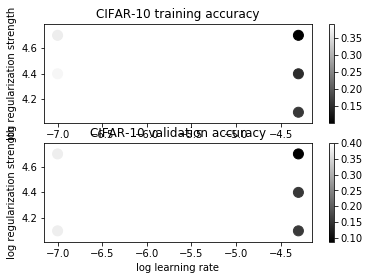

In [40]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [41]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.377000


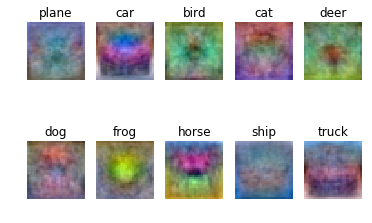

In [42]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*